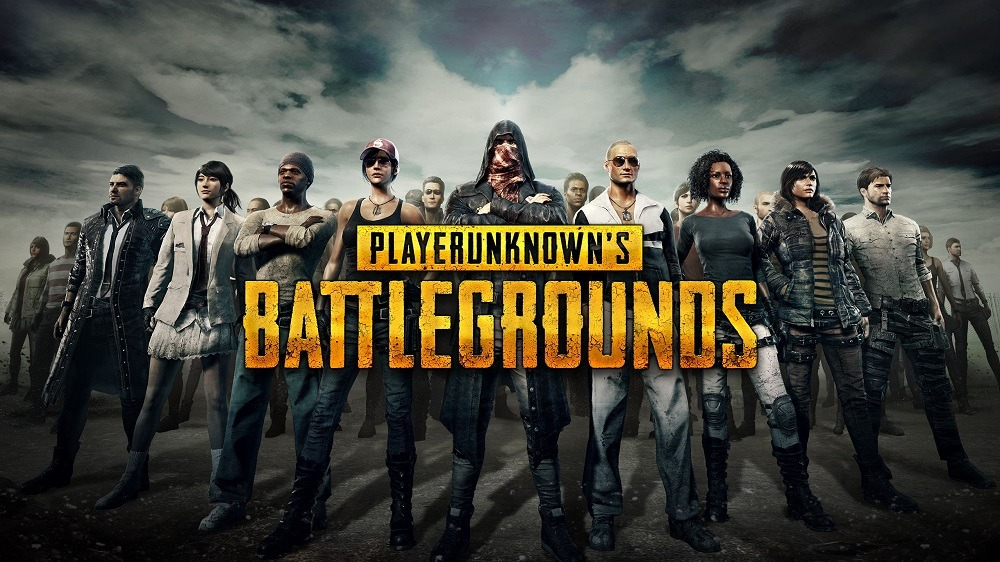

# Unsupervised Learning for Cheater Detection in PlayerUnknowns Battlegrounds (PUBG)

The purpose of this project is to examine different unsupervised learning methods and their application in behavioral cheat detection. 

# Background

A data scientist working for a gaming company has received reports that approximately 1% of the population of their video game is using cheats to have an unfair advantage. With the competitive integrity of the game on the line, the data scientist is tasked in developing a method to detect these cheaters using game logs.

# Data Loading and Engineering

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load the dataset - Downloaded from kaggle

PUBG_DF = pd.read_csv("pubg-finish-placement-prediction/train_V2.csv")

In [3]:
#Display information

PUBG_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

# Variable Information 

DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance - Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.



In [4]:
#Display DF head

PUBG_DF.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
#Copy Original Training Set

PUBG_Orig = PUBG_DF.copy()

#Feature Selection - Dropping columns that don't make sense to check for cheating

PUBG_DF.drop(columns = ['Id','groupId','matchId','rankPoints','weaponsAcquired','weaponsAcquired','teamKills','killPlace','numGroups','DBNOs','maxPlace','winPoints','killPoints'], inplace = True)

In [6]:
#Display DF head

PUBG_DF.head()

,assists,boosts,damageDealt,headshotKills,heals,kills,killStreaks,longestKill,matchDuration,matchType,revives,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,winPlacePerc
0,0,0,0.00,0,0,0,0,0.00,1306,squad-fpp,0,0.0000,0,0.00,0,244.80,0.4444
1,0,0,91.47,0,0,0,0,0.00,1777,squad-fpp,0,0.0045,0,11.04,0,1434.00,0.6400
2,1,0,68.00,0,0,0,0,0.00,1318,duo,0,0.0000,0,0.00,0,161.80,0.7755
3,0,0,32.90,0,0,0,0,0.00,1436,squad-fpp,0,0.0000,0,0.00,0,202.70,0.1667
4,0,0,100.00,0,0,1,1,58.53,1424,solo-fpp,0,0.0000,0,0.00,0,49.75,0.1875


In [7]:
#Feature Engineering

#A high headshot percentage is indicative of a skilled/cheating player 
PUBG_DF['headshotPercentage'] = PUBG_DF['headshotKills'] / PUBG_DF['kills']

#Some cheats allowed for faster travel than the game allowed
PUBG_DF['distanceTraveled'] = PUBG_DF['walkDistance'] + PUBG_DF['rideDistance'] + PUBG_DF['swimDistance']

#Normalize the game match types
PUBG_DF.loc[PUBG_DF['matchType'] == 'squad-fpp','matchType'] = "squad"
PUBG_DF.loc[PUBG_DF['matchType'] == 'duo-fpp','matchType'] = "duo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'solo-fpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-squad-fpp','matchType'] = "squad"
PUBG_DF.loc[PUBG_DF['matchType'] == 'crashfpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-duo-fpp','matchType'] = "duo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-solo-fpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'flaretpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'flarefpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'crashtpp','matchType'] = "solo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-squad','matchType'] = "squad"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-duo','matchType'] = "duo"
PUBG_DF.loc[PUBG_DF['matchType'] == 'normal-solo','matchType'] = "solo"

PUBG_DF['matchType'].value_counts()

squad    2400402
duo      1315970
solo      730594
Name: matchType, dtype: int64

In [8]:
#Look for NaN values

PUBG_DF.isnull().sum()

assists                     0
boosts                      0
damageDealt                 0
headshotKills               0
heals                       0
kills                       0
killStreaks                 0
longestKill                 0
matchDuration               0
matchType                   0
revives                     0
rideDistance                0
roadKills                   0
swimDistance                0
vehicleDestroys             0
walkDistance                0
winPlacePerc                1
headshotPercentage    2529722
distanceTraveled            0
dtype: int64

In [9]:
#Drop NA headshot percentages (indicative of 0 kills)

PUBG_DF.dropna(inplace = True)

PUBG_DF.isnull().sum()

assists               0
boosts                0
damageDealt           0
headshotKills         0
heals                 0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
vehicleDestroys       0
walkDistance          0
winPlacePerc          0
headshotPercentage    0
distanceTraveled      0
dtype: int64

In [10]:
#Change final row to WinPlacePerc

wpp = PUBG_DF.pop('winPlacePerc')
PUBG_DF['winPlacePerc'] = wpp

PUBG_DF.head()

,assists,boosts,damageDealt,headshotKills,heals,kills,killStreaks,longestKill,matchDuration,matchType,revives,rideDistance,roadKills,swimDistance,vehicleDestroys,walkDistance,headshotPercentage,distanceTraveled,winPlacePerc
4,0,0,100.00,0,0,1,1,58.530,1424,solo,0,0.0,0,0.00,0,49.75,0.00,49.75,0.1875
5,0,0,100.00,1,0,1,1,18.440,1395,squad,0,0.0,0,0.00,0,34.70,1.00,34.70,0.0370
13,0,1,324.20,1,5,4,1,49.830,1886,solo,0,1228.0,0,76.84,0,2050.00,0.25,3354.84,0.8750
14,0,1,122.80,0,2,1,1,37.910,1458,squad,1,1237.0,0,60.29,0,1666.00,0.00,2963.29,0.9000
16,0,2,81.71,0,14,1,1,9.158,1882,squad,0,519.9,0,0.00,0,3674.00,0.00,4193.90,0.7308


In [11]:
#Final DF shape

PUBG_DF.shape

(1917244, 19)

# Understanding Cheating and Feature Importance

For a battle royale style game, the most prevalant style cheats are going to be aiming cheats (aimbots), movement cheats, or x-ray vision. 

For aimbots, the most common indicator will be high amounts of kills and high headshot percentage.

For movement cheats, distance traveled will be far outside the average (with walk distance being the main factor as players can travel faster on foot)

X-Ray cheats, or wallhacks, are not going to be examined too closely in the context of this project, but like aimbots, a high kill and high headshot percentage are likely indicators. 

Most of the time, cheaters will use a combination of these to acheive victory

We can examine certain impossible events occuring in the outliers of the dataset to look for cheaters
__________________________


# Battle Royale games prioritize winning over any other statistic, so we will prioritize WinPlacePerc as the most important feature to draw correlations with

<AxesSubplot:>

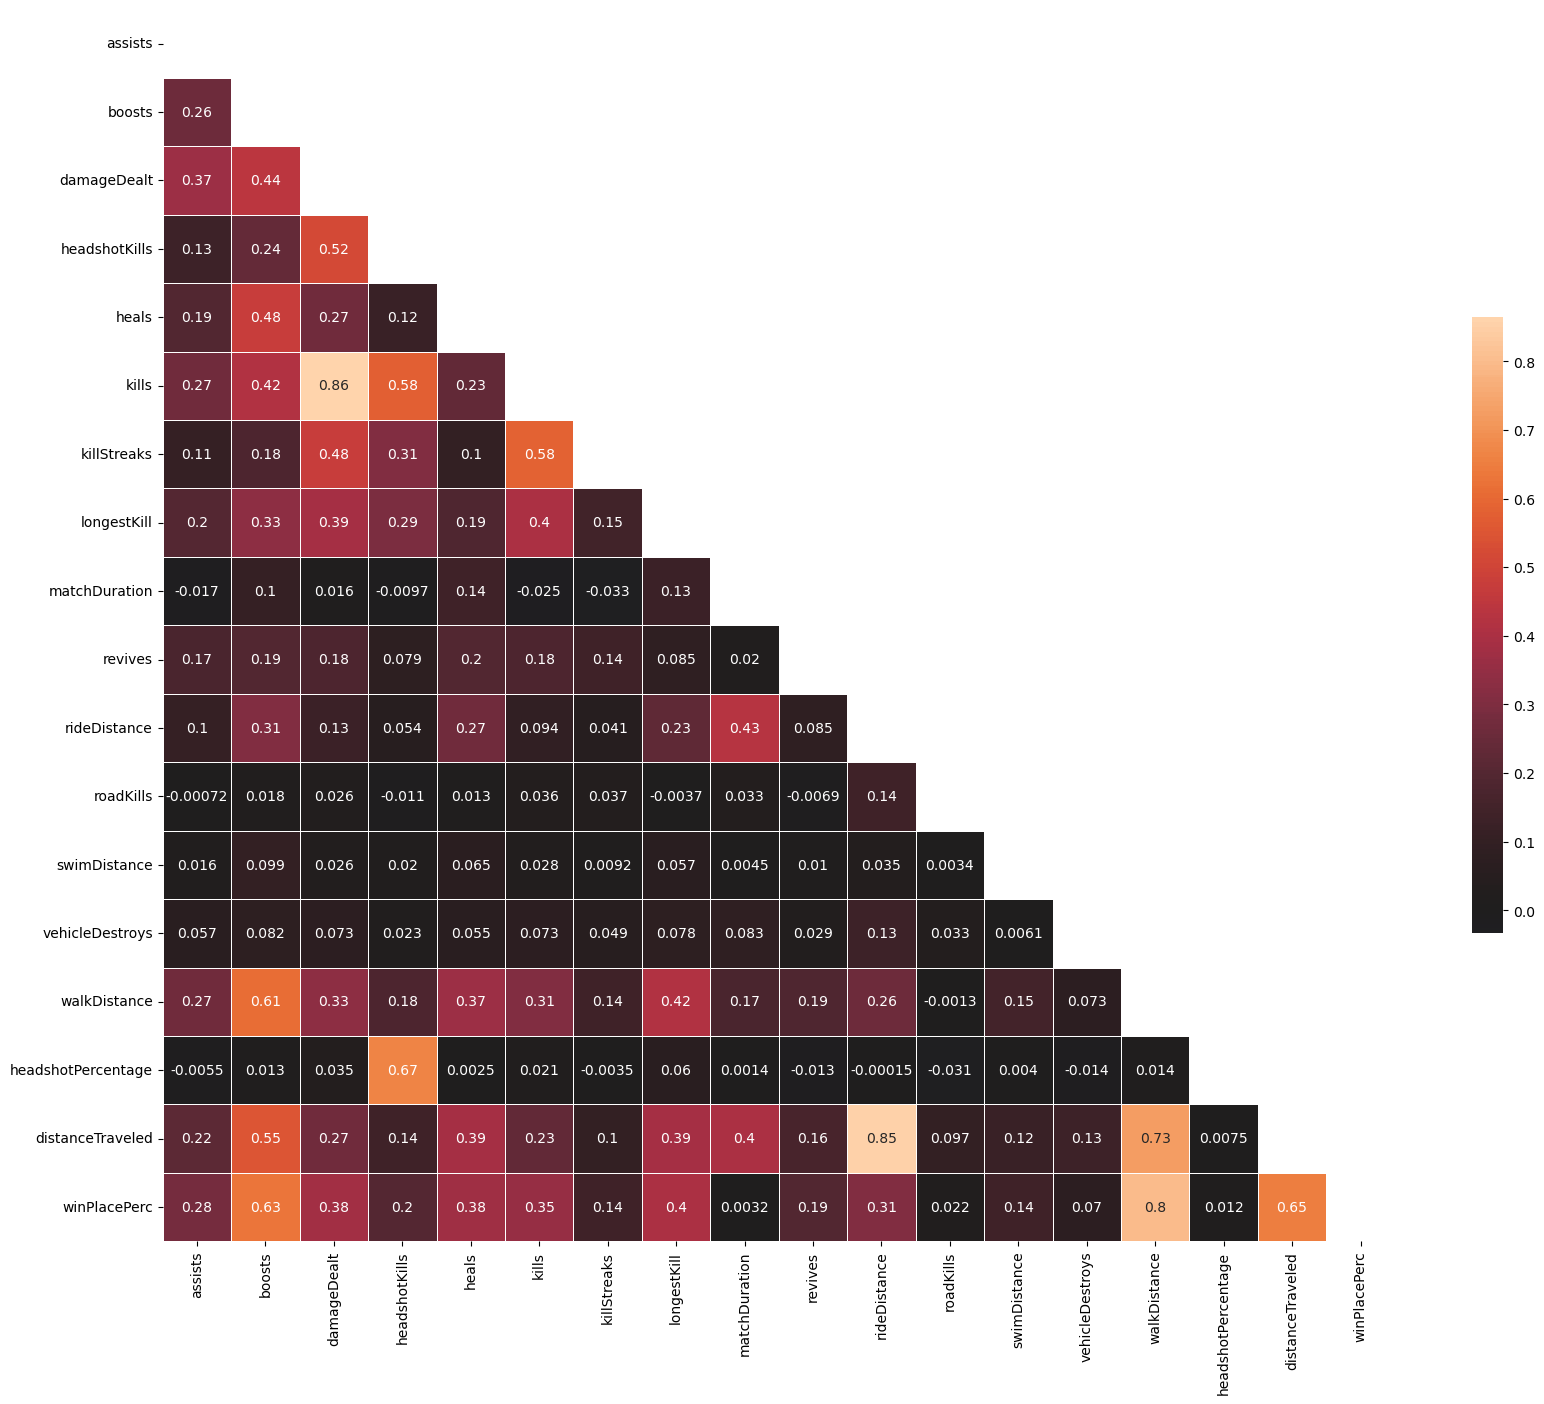

In [12]:
#Correlation Heatmap for Continuous Variables

no_cat_df = PUBG_DF.drop(columns = ['matchType'])

corr = no_cat_df.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(20,16))

sns.heatmap(corr, mask=mask, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Univariate Exploration

Text(0.5, 1.0, 'Win Percentage Distribution')

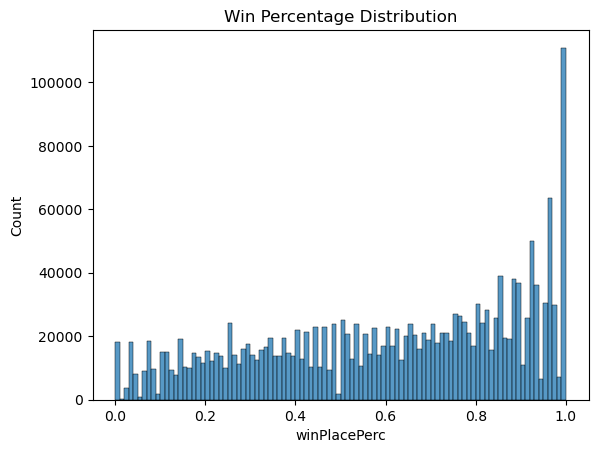

In [13]:
#Win Percentage Distribution (1 = Win)

sns.histplot(data = PUBG_DF, x = 'winPlacePerc', bins = 100)
plt.title("Win Percentage Distribution")

In [14]:
#Win Distribution

Win = PUBG_DF.loc[PUBG_DF['winPlacePerc'] == 1.0]

print(f'Percentage of wins to entire dataset: {round(len(Win) / len(PUBG_DF),3)*100}%')

Percentage of wins to entire dataset: 5.800000000000001%


In [15]:
#Average and Max Kills

Average_Kills = PUBG_DF['kills'].mean()
Max_Kills = PUBG_DF['kills'].max()

print(f'Average Overall Kills: {Average_Kills}, Max Kills: {Max_Kills}')

Average Overall Kills: 2.1449956291426653, Max Kills: 72


Text(0.5, 1.0, 'Kill Distribution')

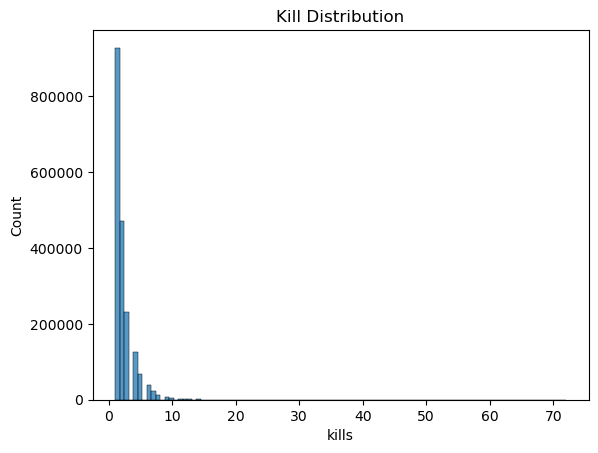

In [16]:
# Histplot

sns.histplot(data = PUBG_DF, x = 'kills', bins = 100)
plt.title("Kill Distribution")

In [17]:
# Look at kills above 95 percentile

Kills_Over_5 = PUBG_DF.loc[PUBG_DF['kills'] > 5]

print(f'Percentage of Kills over 5: {round(len(Kills_Over_5) / len(PUBG_DF),3)*100}%')

Percentage of Kills over 5: 4.9%


Text(0, 0.5, 'Ordered Values')

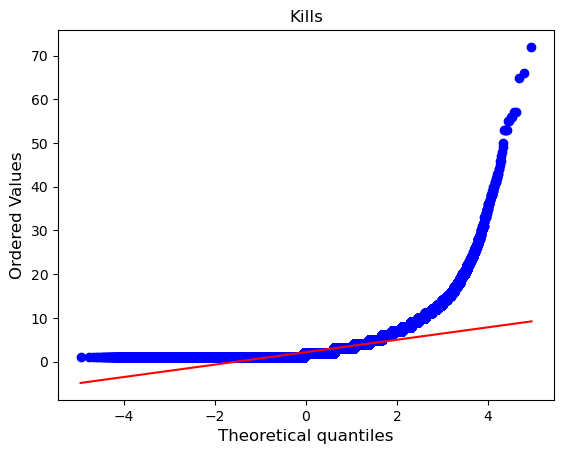

In [18]:
# Probability plots

stats.probplot(PUBG_DF["kills"], plot = sns.mpl.pyplot)
plt.title('Kills', fontsize = 12)
plt.xlabel('Theoretical quantiles', fontsize = 12)
plt.ylabel('Ordered Values', fontsize = 12)

Text(0.5, 1.0, 'Walk Distance')

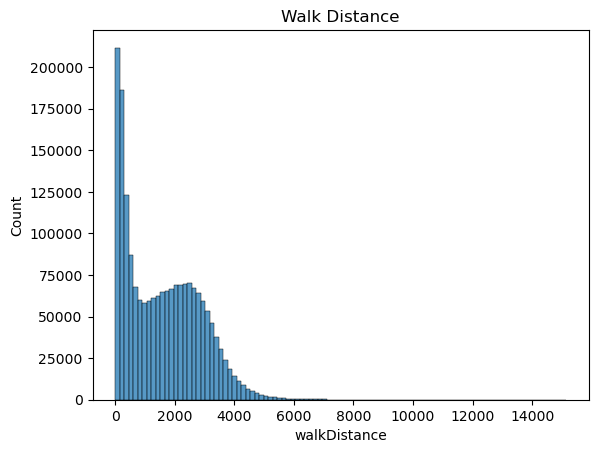

In [19]:
#Walk Distance

sns.histplot(data = PUBG_DF, x = 'walkDistance', bins = 100)
plt.title("Walk Distance")

In [20]:
#Walk Mean, Max

Average_Walk = PUBG_DF['walkDistance'].mean()
Max_Walk = PUBG_DF['walkDistance'].max()

print(f'Average Overall Walk: {Average_Walk}, Max Walk: {Max_Walk}')

Average Overall Walk: 1591.363857941467, Max Walk: 15130.0


In [21]:
# Look at walk distance 95th percentile

Walk_Over_3000 = PUBG_DF.loc[PUBG_DF['walkDistance'] > 3500]

print(f'Percentage of walk distance over 3500: {round(len(Walk_Over_3000) / len(PUBG_DF),3)*100} %')

Percentage of walk distance over 3500: 6.9 %


Text(0, 0.5, 'Ordered Values')

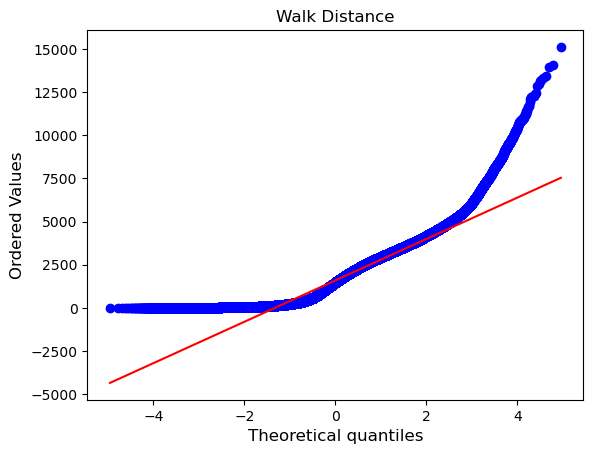

In [22]:
#Probability 

stats.probplot(PUBG_DF["walkDistance"], plot = sns.mpl.pyplot)
plt.title('Walk Distance', fontsize = 12)
plt.xlabel('Theoretical quantiles', fontsize = 12)
plt.ylabel('Ordered Values', fontsize = 12)

Text(0.5, 1.0, 'Boosts')

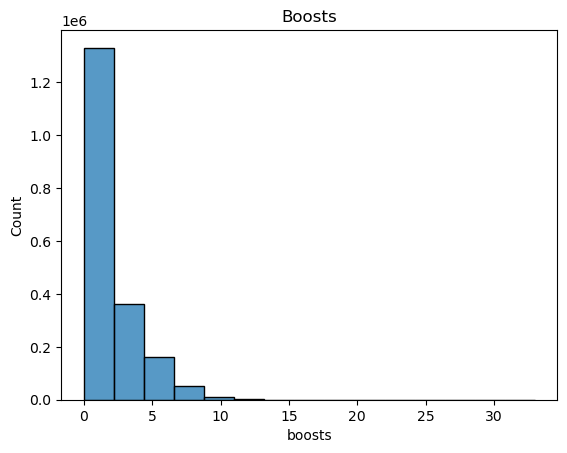

In [23]:
#Boosts

sns.histplot(data = PUBG_DF, x = 'boosts', bins = 15)
plt.title("Boosts")

In [24]:
#Mean and Max Boosts

boosts_mean = PUBG_DF['boosts'].mean()
boosts_max = PUBG_DF['boosts'].max()
print(f'Boosts Mean: {boosts_mean} , Max Amount of Boosts: {boosts_max}')

Boosts Mean: 1.8665605421114893 , Max Amount of Boosts: 33


In [25]:
# Look at boost 95 percentile

Boost_95 = PUBG_DF.loc[PUBG_DF['boosts'] > 5]

print(f'Percentage of boosts above 5: {round(len(Boost_95)*100 / len(PUBG_DF),3)} %')

Percentage of boosts above 5: 6.593 %


Text(0, 0.5, 'Ordered Values')

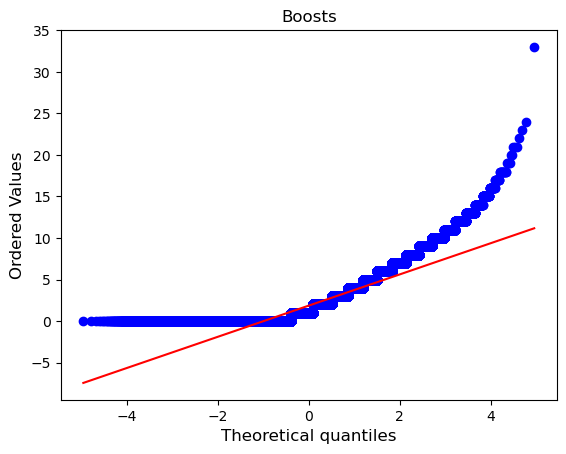

In [26]:
stats.probplot(PUBG_DF["boosts"], plot = sns.mpl.pyplot)
plt.title('Boosts', fontsize = 12)
plt.xlabel('Theoretical quantiles', fontsize = 12)
plt.ylabel('Ordered Values', fontsize = 12)

Text(0.5, 1.0, 'Longest Kill')

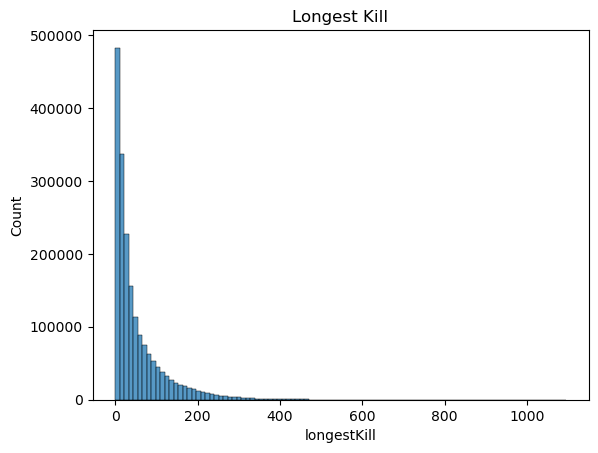

In [27]:
#Longest Kill

sns.histplot(data = PUBG_DF, x = 'longestKill', bins = 100)
plt.title("Longest Kill")

In [28]:
#Mean and Max Longest Kill

longest_kill_mean = PUBG_DF['longestKill'].mean()
longest_kill_max = PUBG_DF['longestKill'].max()

print(f'Longest Kill Mean: {longest_kill_mean}, Longest Kill Max: {longest_kill_max}')

Longest Kill Mean: 53.341944144303675, Longest Kill Max: 1094.0


In [29]:
#95% percentile

longest_95 = PUBG_DF.loc[PUBG_DF['longestKill'] > 200]

print(f'Percentage of longest kill greater than 200: {round(len(longest_95) / len(PUBG_DF),3)*100} %')

Percentage of longest kill greater than 200: 4.3 %


Text(0, 0.5, 'Ordered Values')

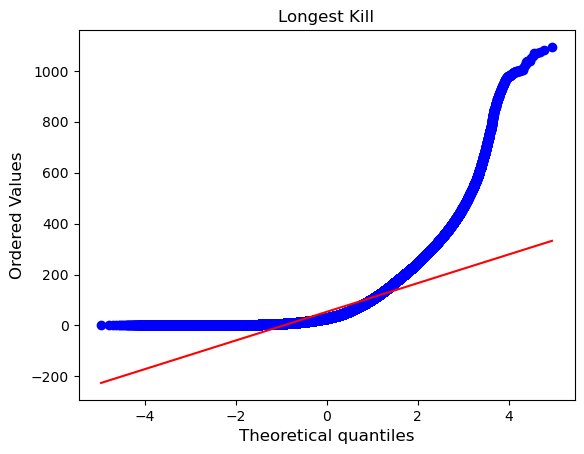

In [30]:
stats.probplot(PUBG_DF["longestKill"], plot = sns.mpl.pyplot)
plt.title('Longest Kill', fontsize = 12)
plt.xlabel('Theoretical quantiles', fontsize = 12)
plt.ylabel('Ordered Values', fontsize = 12)

Text(0.5, 1.0, 'Damage Dealt')

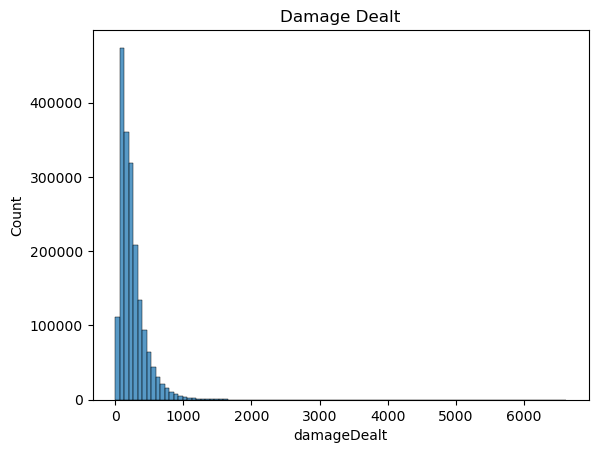

In [31]:
#Damage Dealt

sns.histplot(data = PUBG_DF, x = 'damageDealt', bins = 100)
plt.title("Damage Dealt")

Text(0.5, 1.0, 'Headshot Percentage')

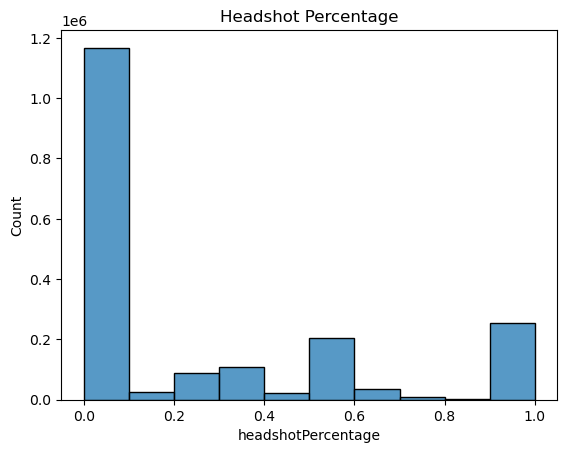

In [32]:
#Headshot Percentage

sns.histplot(data = PUBG_DF, x = 'headshotPercentage', bins = 10)
plt.title("Headshot Percentage")

# Bivariate Exploration

Text(0.5, 1.0, 'Kills vs. Win Place')

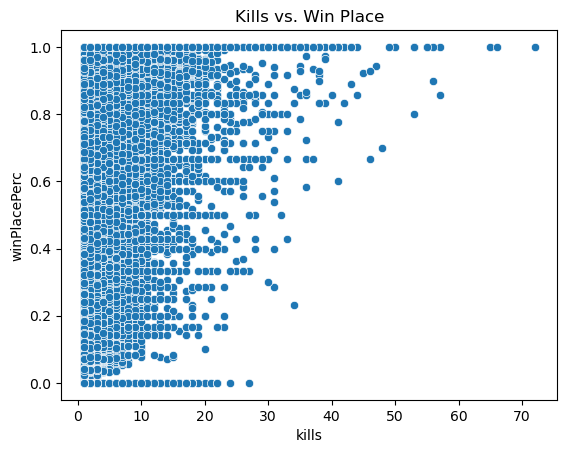

In [33]:
#Kills vs. Place (closer to 1 means higher placement)

sns.scatterplot(data = PUBG_DF, x = "kills", y = "winPlacePerc")
plt.title("Kills vs. Win Place")

Text(0.5, 1.0, 'Kills vs. Headshot Kills')

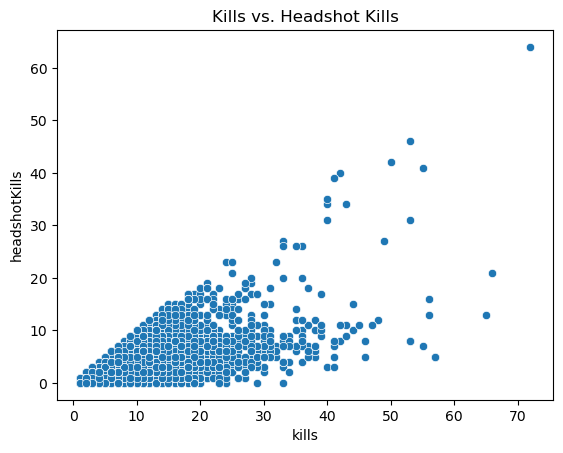

In [34]:
#Examining the relationship between kill counts and headshot kills
sns.scatterplot(data = PUBG_DF, x = "kills", y = "headshotKills")
plt.title("Kills vs. Headshot Kills")

There seems to be some markings of a linear relationship here in the higher outliers

Average Kills: 2.1449956291426653, Average Distance Traveled: 2368.2053743570377


Text(0.5, 1.0, 'Kills vs. Distance Traveled')

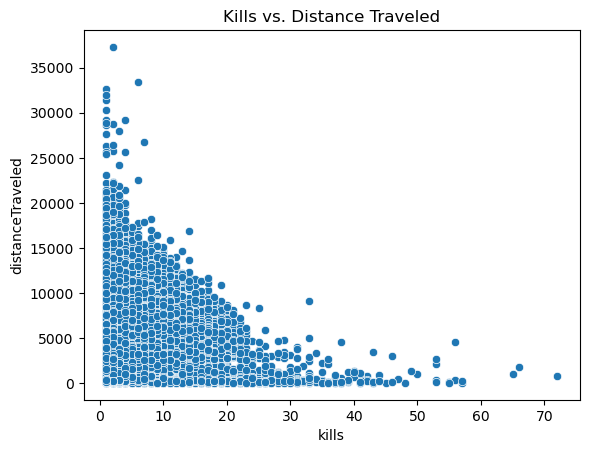

In [35]:
#Examining Kills vs. Distance Traveled to look for interesting relationships

Average_Distance = PUBG_DF['distanceTraveled'].mean()
print(f'Average Kills: {Average_Kills}, Average Distance Traveled: {Average_Distance}')

sns.scatterplot(data = PUBG_DF, x = "kills", y = "distanceTraveled")
plt.title("Kills vs. Distance Traveled")

Another linear looking graph with the highest kills correlating to low distance traveled - an impossible event for a real player.

Average Kills: 2.1449956291426653, Average Longest Kill: 53.341944144303675


Text(0.5, 1.0, 'Kills vs. Longest Kill')

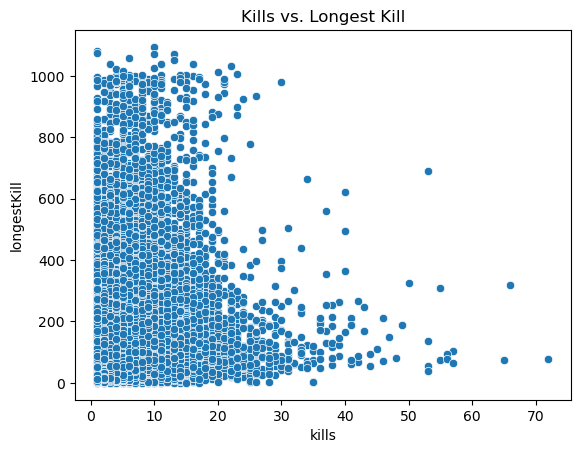

In [36]:
#Kills vs. Longest Kill

Average_longest = PUBG_DF['longestKill'].mean()
print(f'Average Kills: {Average_Kills}, Average Longest Kill: {Average_longest}')

sns.scatterplot(data = PUBG_DF, x = "kills", y = "longestKill")
plt.title("Kills vs. Longest Kill")

Average Kills: 2.1449956291426653, Average Kill Streak: 1.2616808293571398


Text(0.5, 1.0, 'Kills vs. Killstreaks')

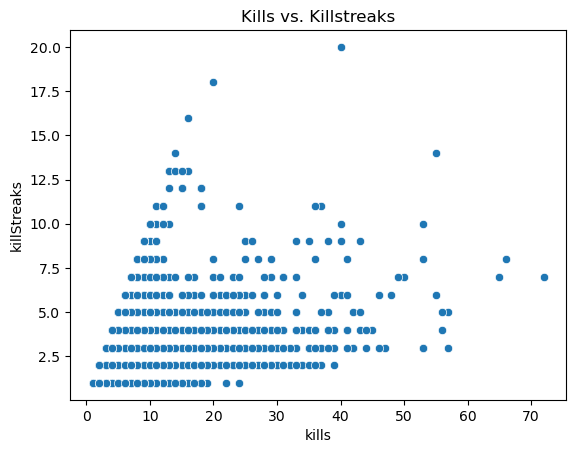

In [37]:
#Kills vs. Killstreaks

Average_killstreak = PUBG_DF['killStreaks'].mean()
print(f'Average Kills: {Average_Kills}, Average Kill Streak: {Average_killstreak}')

sns.scatterplot(data = PUBG_DF, x = "kills", y = "killStreaks")
plt.title("Kills vs. Killstreaks")

Average Kills: 2.1449956291426653, Average Match Duration: 1571.3410577892016


Text(0.5, 1.0, 'Kills vs. Match Duration')

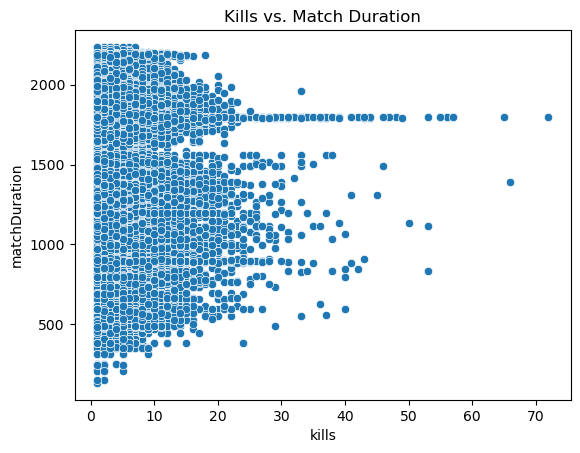

In [38]:
#Kills vs. Match Duration

Average_matchd = PUBG_DF['matchDuration'].mean()
print(f'Average Kills: {Average_Kills}, Average Match Duration: {Average_matchd}')

sns.scatterplot(data = PUBG_DF, x = "kills", y = "matchDuration")
plt.title("Kills vs. Match Duration")

Text(0.5, 1.0, 'Kills vs. Match Type')

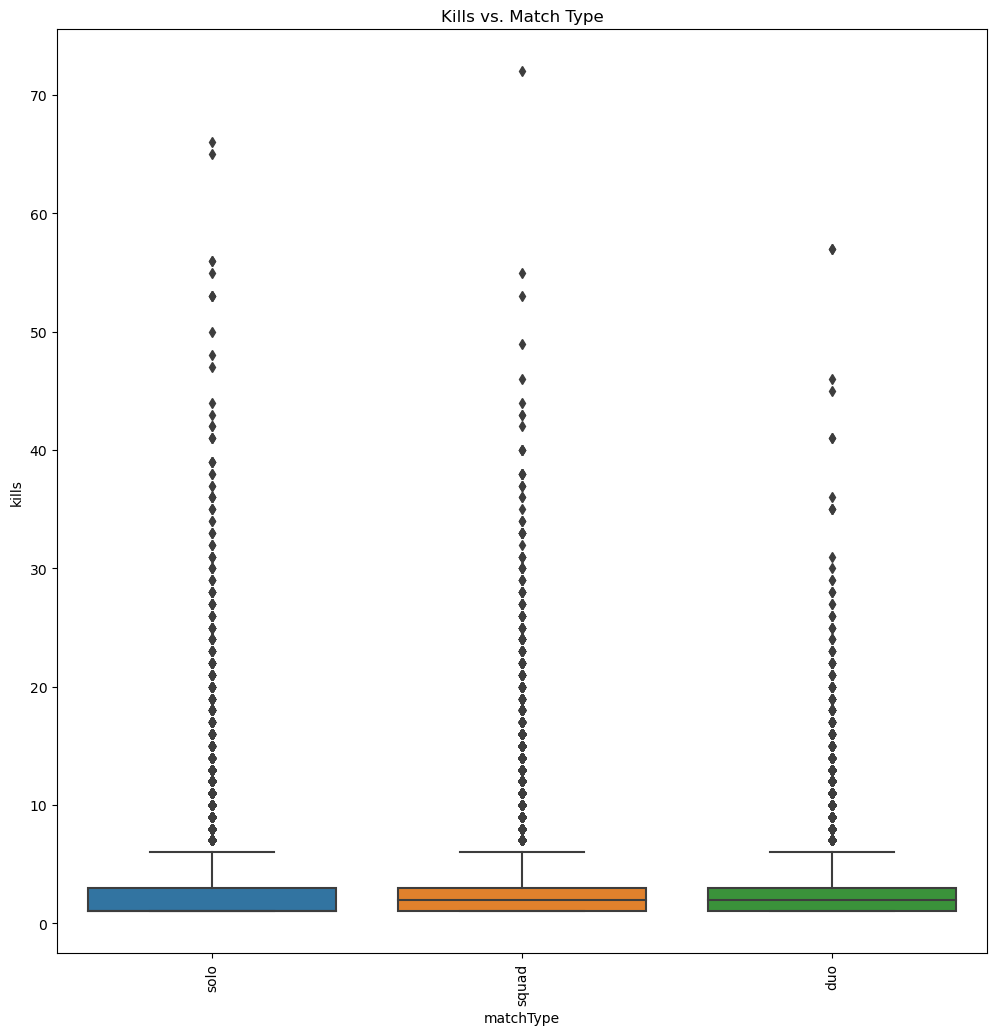

In [39]:
#Kills vs. Match Type

plt.figure(figsize=(12,12))
sns.boxplot(data = PUBG_DF, x = "matchType", y = "kills")
plt.xticks(rotation=90)
plt.title("Kills vs. Match Type")

# Multivariate Kills Exploration

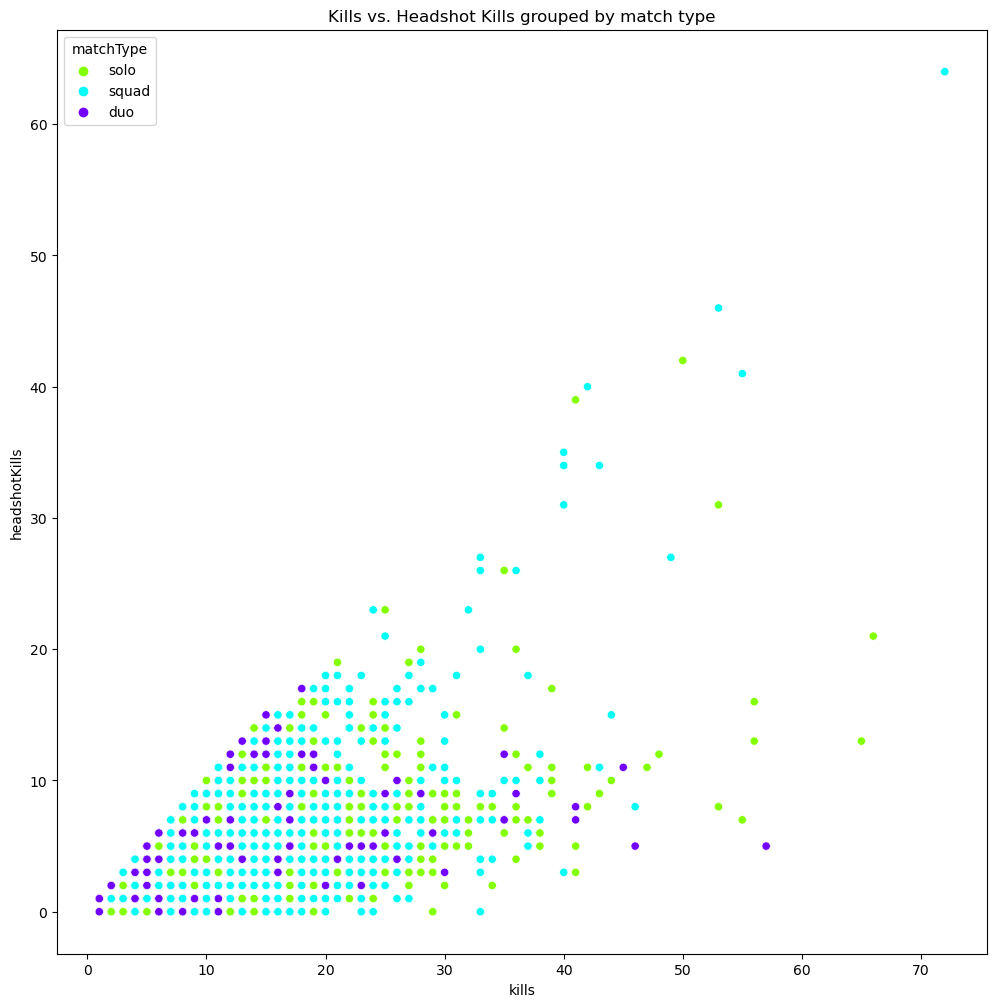

In [40]:
#Kills vs Headshot Kills grouped by match type
with sns.color_palette("hsv", n_colors=3):
    plt.figure(figsize=(12,12))
    sns.scatterplot(data = PUBG_DF, x = "kills", y = "headshotKills", hue = 'matchType')
    plt.title("Kills vs. Headshot Kills grouped by match type")

# Clustering Unlabeled Data


Since this dataset does not have labels to tell us whether a player was cheating or not, we have to infer this from other methodology. 

The first technique to apply is K Means clustering, an unsupervised method that will attempt to group the dataset into a number of clusters. The hope is that one of the clusters will encompass most of these outliers and we can continue to narrow down the dataset.

In [41]:
from sklearn.cluster import KMeans

Cluster_X = PUBG_DF.drop(columns = ['killStreaks','damageDealt','assists','heals', 'roadKills','swimDistance','distanceTraveled','matchType','matchDuration','rideDistance','revives','vehicleDestroys'])

(array([-5.0e+11,  0.0e+00,  5.0e+11,  1.0e+12,  1.5e+12,  2.0e+12,
         2.5e+12,  3.0e+12,  3.5e+12]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

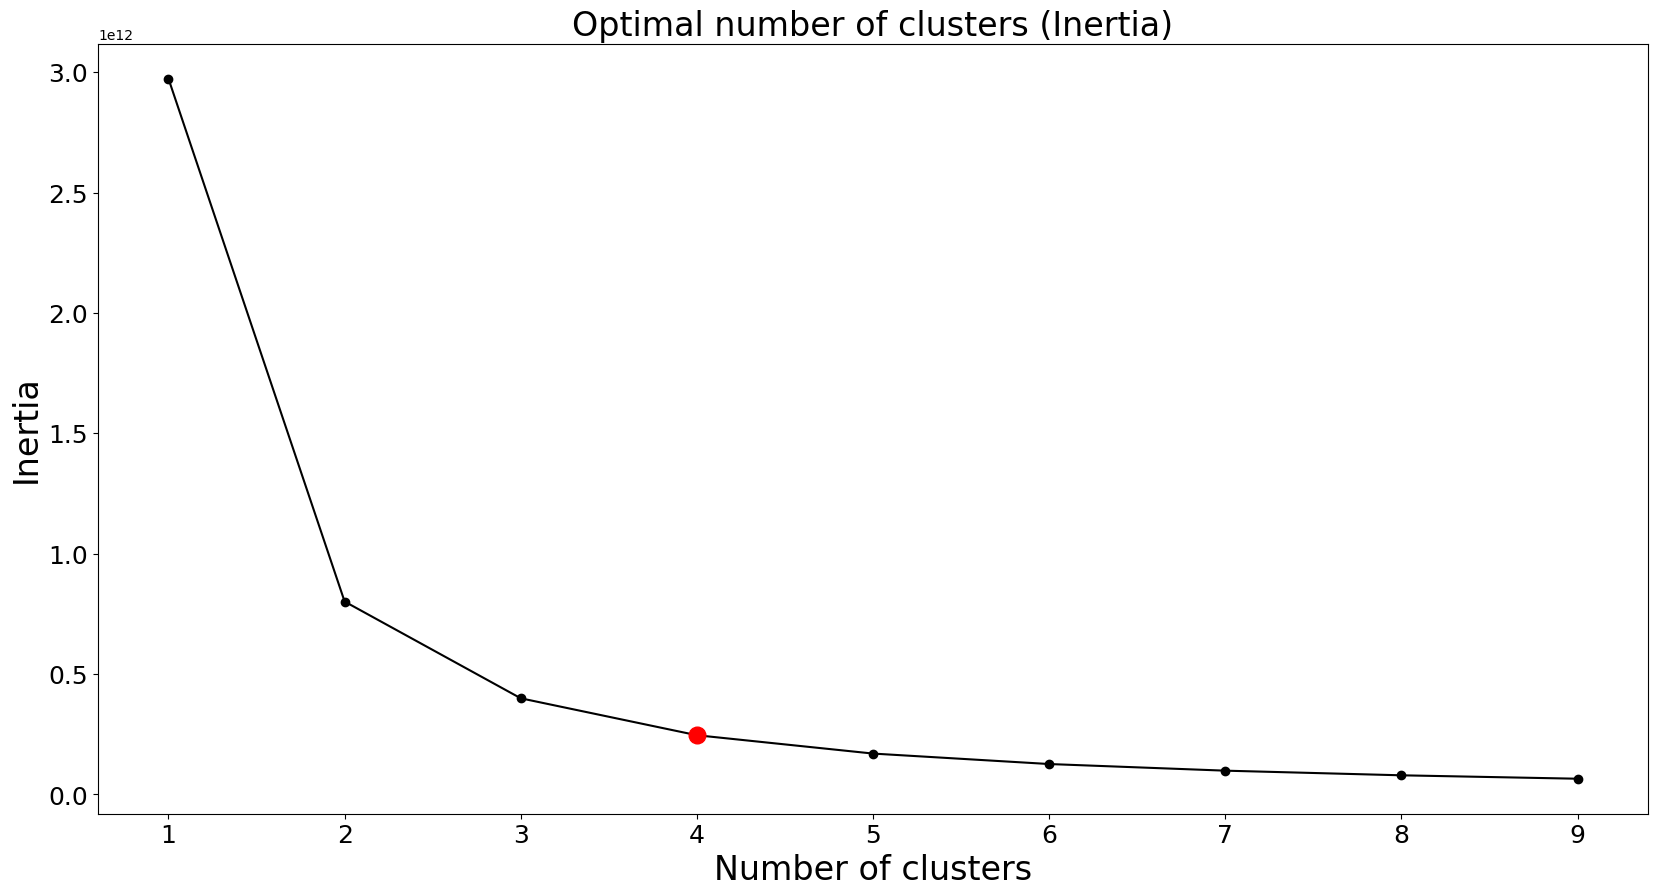

In [42]:
#Create a search for the optimal number of clusters

ks = range(1, 10)

inertias = []

for k in ks:
   
    # Create a KMeans instance with k clusters: model
    
    model = KMeans(n_clusters=k, init='k-means++', random_state = 42)
    
    # Fit model to samples
    model.fit(Cluster_X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot parameters
plt.figure(figsize = (20, 10))
plt.plot(ks, inertias, '-o', color = 'black')
plt.plot(4, inertias[3], '-o', color = 'red', markersize = 12)
plt.xlabel('Number of clusters', fontsize = 24)
plt.ylabel('Inertia', fontsize = 24)
plt.title('Optimal number of clusters (Inertia)', fontsize = 24)
plt.xticks(ks, fontsize = 18)
plt.yticks(fontsize = 18)

In [45]:
#Instantiate the KMeans Model and predict on the training set

kmeans = KMeans(n_clusters = 4)

label = kmeans.fit_predict(Cluster_X)

centroids = kmeans.cluster_centers_

In [46]:
#Send labels to dataframe and display sample

Cluster_X['label'] = label.tolist()

Cluster_X.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
2890194,4,0,2,5.1410,668.60,0.000000,0.3810,2
1321128,1,0,1,9.6270,2544.00,0.000000,0.5862,0
880486,1,0,2,58.4700,1031.00,0.000000,0.4231,1
237144,1,0,1,0.6965,152.10,0.000000,0.2400,2
1344588,1,0,3,42.8700,2007.00,0.000000,0.6923,1
87868,2,0,1,17.1100,1325.00,0.000000,0.8958,1
2003181,2,2,5,88.8900,2195.00,0.400000,0.8542,0
2665104,0,0,1,1.0550,135.10,0.000000,0.1481,2
3925670,0,1,1,26.7300,126.20,1.000000,0.3261,2
4215981,5,2,7,23.6800,1858.00,0.285714,0.8148,1


<AxesSubplot:>

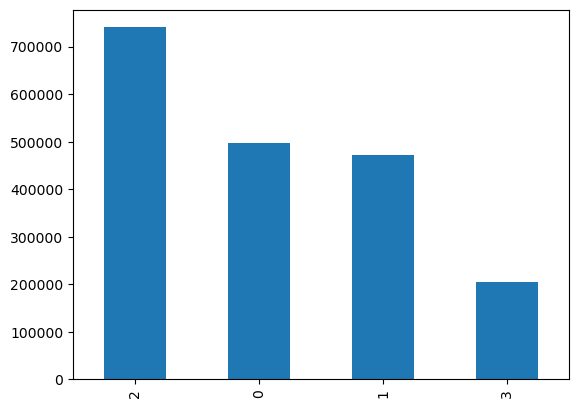

In [47]:
#Plot Label distribution

label_values = Cluster_X['label'].value_counts()

label_values.plot(kind = 'bar')

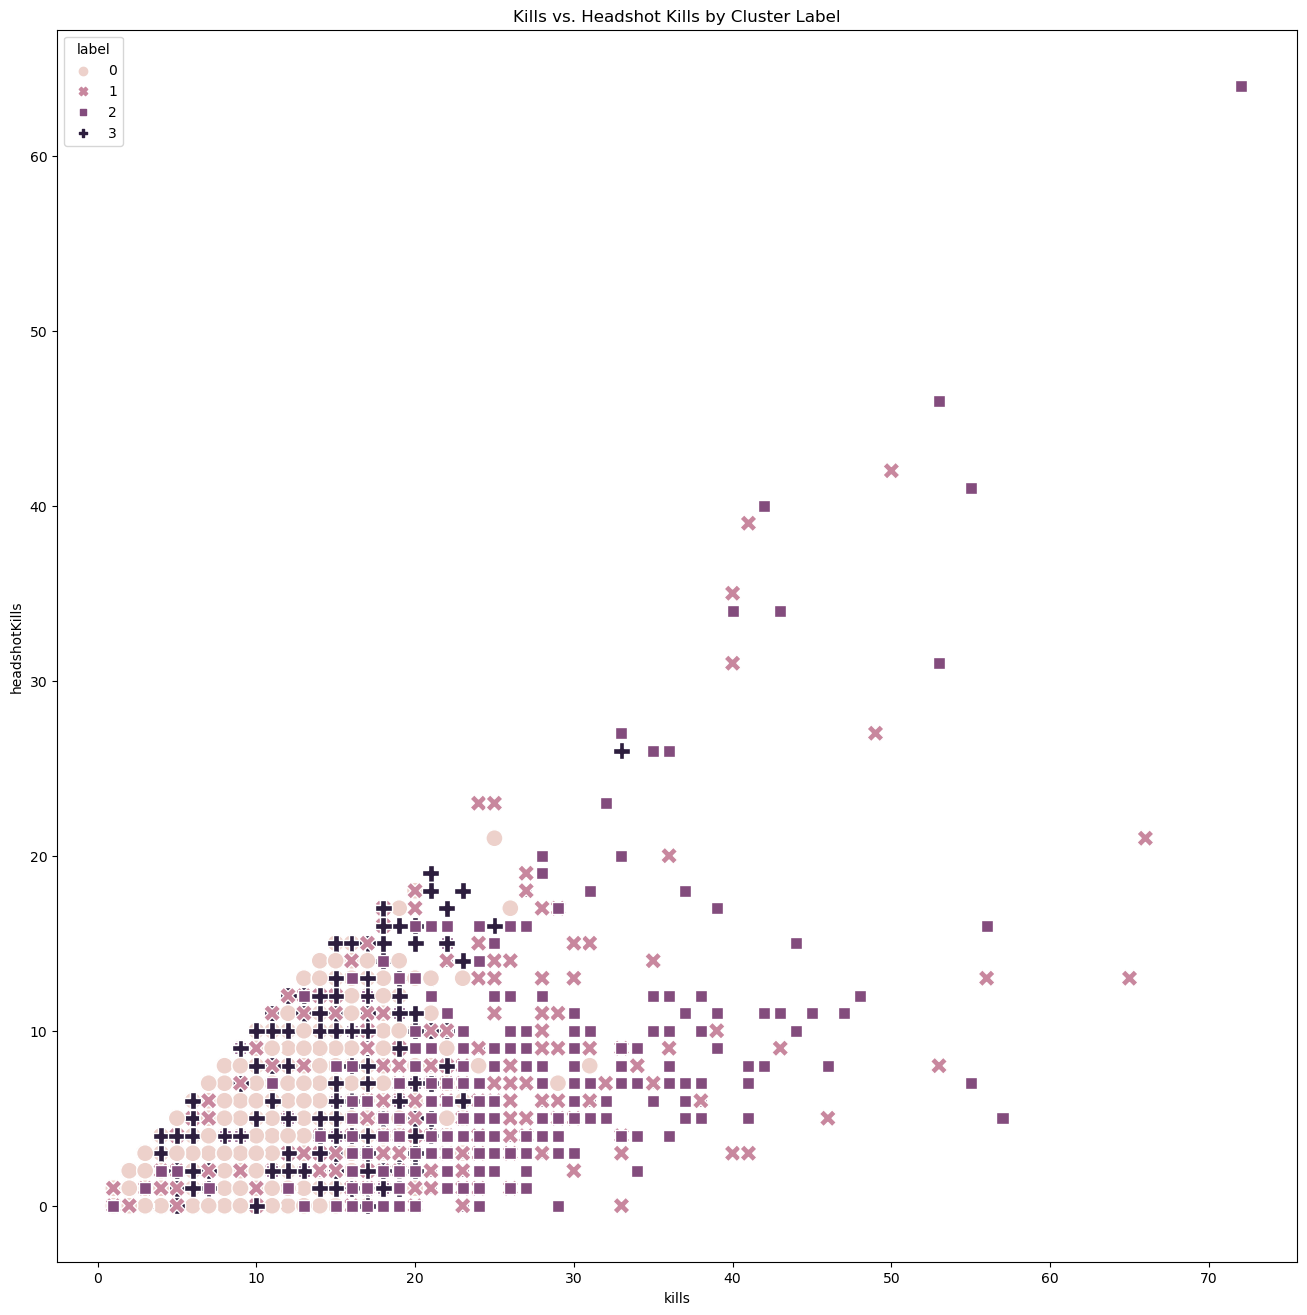

In [56]:
with sns.color_palette("hsv"):
    plt.figure(figsize=(16,16))
    sns.scatterplot(data = Cluster_X, x = 'kills', y = 'headshotKills',style ='label',hue = 'label',s=150)
    plt.title("Kills vs. Headshot Kills by Cluster Label")

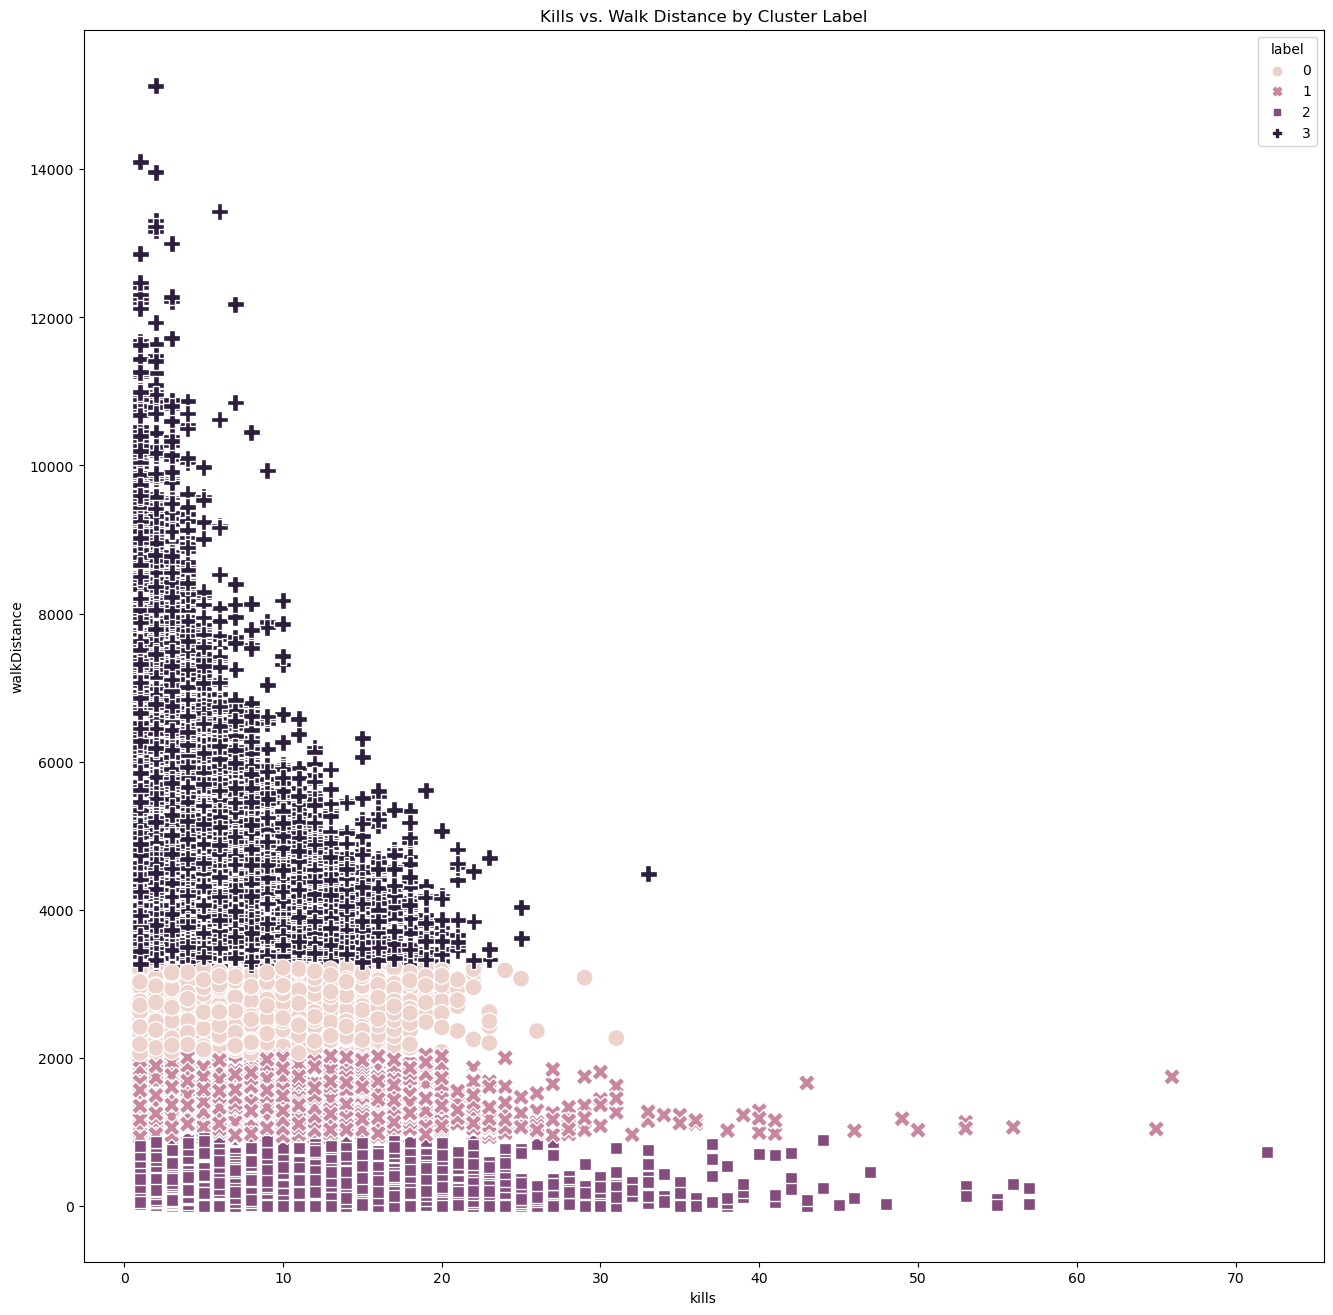

In [57]:
with sns.color_palette("hsv"):
    plt.figure(figsize=(16,16))
    sns.scatterplot(data = Cluster_X, x = 'kills', y = 'walkDistance',style ='label',hue = 'label',s=150)
    plt.title("Kills vs. Walk Distance by Cluster Label")

<AxesSubplot:>

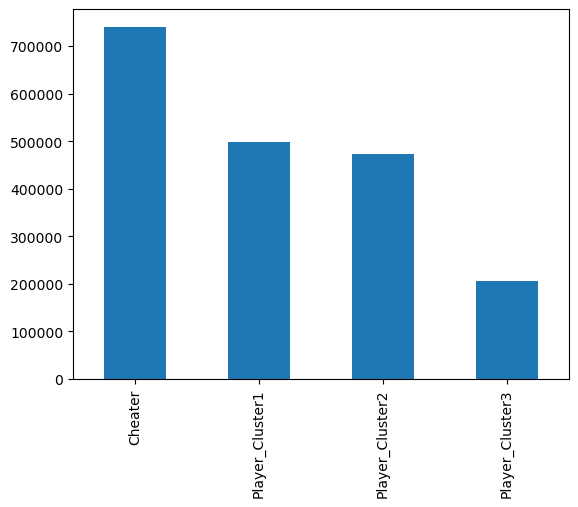

In [59]:
#Update labels

Cluster_X.loc[Cluster_X["label"] == 0, "label"] = "Player_Cluster1"
Cluster_X.loc[Cluster_X["label"] == 1, "label"] = "Player_Cluster2"
Cluster_X.loc[Cluster_X["label"] == 2, "label"] = "Cheater"
Cluster_X.loc[Cluster_X["label"] == 3, "label"] = "Player_Cluster3"

label_values = Cluster_X['label'].value_counts()

label_values.plot(kind = 'bar')

In [60]:
#View sample from Cheaters

Hacker_X = Cluster_X.loc[Cluster_X["label"] == 'Cheater']

Hacker_X.sample(n = 20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
451310,0,0,1,6.400,92.39,0.000000,0.2143,Cheater
948510,0,0,1,13.750,325.20,0.000000,0.5161,Cheater
1947997,0,0,1,10.450,394.50,0.000000,0.4043,Cheater
1608293,0,1,1,67.250,691.50,1.000000,0.3462,Cheater
2156397,0,0,2,16.760,835.40,0.000000,0.6875,Cheater
4175065,1,0,2,17.290,333.40,0.000000,0.3438,Cheater
52813,0,1,1,89.830,350.70,1.000000,0.3617,Cheater
4252904,0,1,2,7.196,491.20,0.500000,0.2143,Cheater
1781474,1,0,1,12.700,482.60,0.000000,0.2708,Cheater
163049,0,0,3,8.293,733.30,0.000000,0.5208,Cheater


In [63]:
#Percentage of Cheaters

print(f' Percentage of Cheaters: {len(Hacker_X) / len(Cluster_X)}%')

 Percentage of Cheaters: 0.3863848315603022%


So according to this clustering, about 38% of the players are cheaters. The clustering algorithm is not concerned with outliers, instead grouping players that maintain impossible events, and regular players. 

We can without a doubt say that K-Means clustering is not an applicable methodology for detecting cheaters.

# Outlier Detection

Outlier detection is also known as anomaly detection for unsupervised learning, and is a great method for looking at unusual events or observations. 

The local outlier factor measures the local deviation of a data point with respect to it's neighbors.The anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers 

(https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)

In [64]:
#Instantiate LOF Model and predict on training set

from sklearn.neighbors import LocalOutlierFactor

Outlier_X = PUBG_DF.drop(columns = ['killStreaks','damageDealt','assists','heals', 'roadKills','swimDistance','distanceTraveled','matchType','matchDuration','rideDistance','revives','vehicleDestroys'])

#Model - Novelty has to be set to false in order to make predictions on a training set

lof = LocalOutlierFactor(novelty=False)

outlier_predictions = lof.fit_predict(Outlier_X)

In [65]:
#Add labels to Dataframe

Outlier_X['label'] = outlier_predictions.tolist()

<AxesSubplot:>

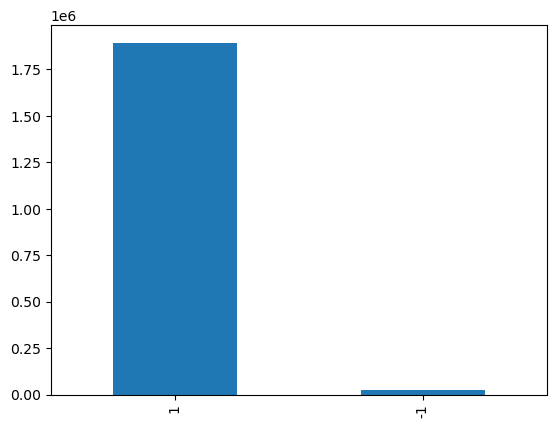

In [66]:
#Distribution of Labels

Outlier_X['label'].value_counts().plot(kind = 'bar')

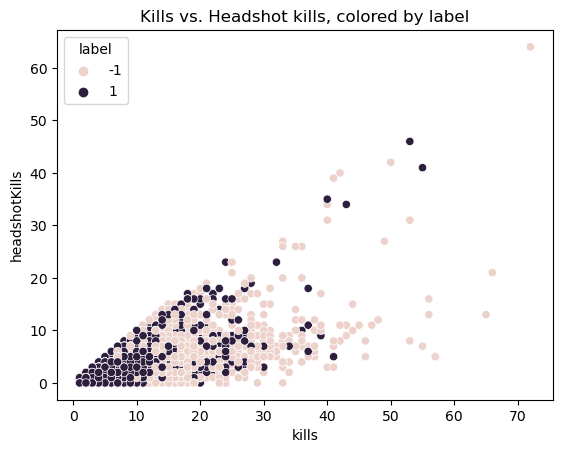

In [67]:
#Scatterplots on most influntial variables

with sns.color_palette("hsv", n_colors=4):
    sns.scatterplot(x = 'kills', y = 'headshotKills', hue = 'label', data = Outlier_X)
    plt.title("Kills vs. Headshot kills, colored by label")

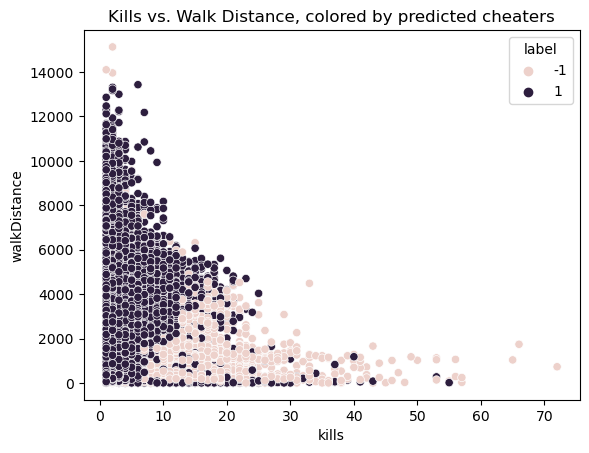

In [68]:
with sns.color_palette("viridis", n_colors=4):
    sns.scatterplot(x = 'kills', y = 'walkDistance', hue = 'label', data = Outlier_X)
    plt.title("Kills vs. Walk Distance, colored by predicted cheaters")

This method looks much better at dividing which players are exhibiting impossible behaviors like high kills/high headshots, and high kills with 0 walk distance. We'll go ahead and assign -1 labels (outliers) to the cheater label.

In [69]:
Outlier_X.loc[Outlier_X["label"] == 1, "label"] = "Normal Player"
Outlier_X.loc[Outlier_X["label"] == -1, "label"] = "Cheater"

In [70]:
Outlier_X.sample(20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
1433267,7,0,6,339.600,3314.00,0.000000,1.0000,Normal Player
3737793,5,1,2,180.200,5031.00,0.500000,0.9655,Normal Player
4363598,1,0,1,12.280,598.00,0.000000,0.6383,Normal Player
3629078,0,0,1,3.808,1139.00,0.000000,0.3103,Normal Player
1541425,6,2,4,191.700,3045.00,0.500000,1.0000,Normal Player
691817,1,0,1,0.000,2492.00,0.000000,0.7742,Normal Player
3978981,5,2,7,157.300,1771.00,0.285714,0.9535,Normal Player
2388646,3,0,1,35.750,971.60,0.000000,0.4348,Normal Player
1758716,1,2,2,13.020,268.30,1.000000,0.3571,Normal Player
2728566,0,0,2,6.035,1512.00,0.000000,0.6633,Normal Player


In [75]:
Negative_Outliers = Outlier_X.loc[Outlier_X["label"] == 'Cheater']

Negative_Outliers.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
1917344,1,0,1,3.1350,54.53,0.000000,0.0833,Cheater
1069889,0,2,9,50.3300,460.70,0.222222,0.3333,Cheater
1477100,0,0,1,1.4750,53.86,0.000000,0.8372,Cheater
95208,4,4,11,58.5300,1531.00,0.363636,1.0000,Cheater
746355,3,3,9,53.2300,367.20,0.333333,0.5652,Cheater
794621,10,0,1,10.1800,2088.00,0.000000,0.8571,Cheater
1886730,3,0,3,1.8370,678.30,0.000000,0.3846,Cheater
4226222,11,0,2,63.0100,1988.00,0.000000,0.9348,Cheater
481090,0,1,2,2.1550,41.95,0.500000,0.0345,Cheater
1859639,0,3,14,57.4000,287.00,0.214286,0.8500,Cheater


In [72]:
Negative_Outliers.shape

(22317, 8)

In [76]:
print(f'Percentage of cheaters to population: {len(Negative_Outliers)/len(Outlier_X)}%')

Percentage of cheaters to population: 0.011640145959512717%


The outlier detection method is much more clear in dividing the more impossible feats into the cheater category, while only selecting 1% of the population. This is promising.

# Rule Based Classifier for Labeling

Using game knowledge, most correlated variables and impossible events, we can write our own rules to attempt to divide the population and isolate the cheaters.

In [97]:
#Recreate the training set

Rule_Based_DF = PUBG_DF.drop(columns = ['killStreaks','damageDealt','assists','heals', 'roadKills','swimDistance','distanceTraveled','matchType','matchDuration','rideDistance','revives','vehicleDestroys'])

Rule_Based_DF

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc
4,0,0,1,58.530,49.75,0.00,0.1875
5,0,1,1,18.440,34.70,1.00,0.0370
13,1,1,4,49.830,2050.00,0.25,0.8750
14,1,0,1,37.910,1666.00,0.00,0.9000
16,2,0,1,9.158,3674.00,0.00,0.7308
...,...,...,...,...,...,...,...
4446950,0,0,1,11.270,1559.00,0.00,0.5000
4446957,1,0,1,12.020,363.70,0.00,0.4583
4446960,0,2,4,90.250,845.60,0.50,0.2414
4446964,4,1,2,98.500,2748.00,0.50,0.8000


In [98]:
#Use arbitrary numbers to create a rule and see what the percentage of cheaters detected is

def first_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['kills'] > 10 and row['boosts'] > 5 and row['longestKill'] > 100 and row['winPlacePerc'] > 0.50 and row['walkDistance'] > 3000 and row['headshotPercentage'] > 0.75:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [99]:
#Arbitrary Rules

Rule_Based_DF['label'] = first_predict(Rule_Based_DF)

In [100]:
#Let's take a look at the suspected cheaters

Rule_Based_Cheaters = Rule_Based_DF.loc[Rule_Based_DF['label'] == 1]

Rule_Based_Cheaters.sample(20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
1708030,7,10,12,190.6,3219.0,0.833333,1.0000,1
3840888,19,26,33,227.2,4485.0,0.787879,1.0000,1
2609167,6,14,16,310.6,4064.0,0.875000,1.0000,1
2244590,7,14,16,301.7,3415.0,0.875000,1.0000,1
355186,6,9,11,135.6,3558.0,0.818182,1.0000,1
882520,12,10,13,359.9,3762.0,0.769231,1.0000,1
3748613,6,13,17,331.9,3218.0,0.764706,0.9231,1
1362616,6,14,15,538.4,3815.0,0.933333,1.0000,1
2191983,6,18,21,945.3,3655.0,0.857143,1.0000,1
4149621,7,12,15,283.6,3426.0,0.800000,1.0000,1


Text(0.5, 1.0, 'Kills vs. Headshot kills, colored by label')

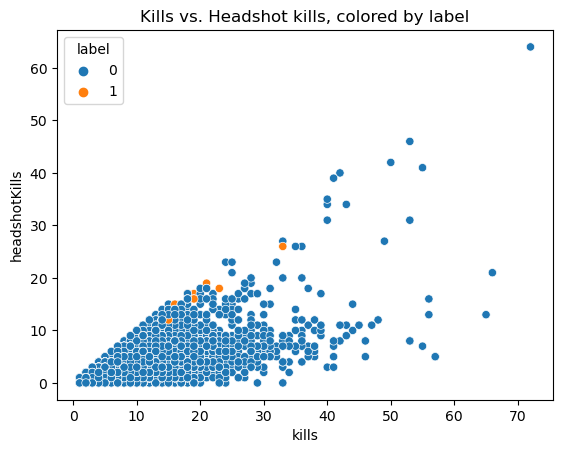

In [101]:
sns.scatterplot(x = 'kills', y = 'headshotKills', hue = 'label', data = Rule_Based_DF)
plt.title("Kills vs. Headshot kills, colored by label")

In [102]:
Arbitrary_Rules = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Percentage of players selected as cheaters: {Arbitrary_Rules}')

Percentage of players selected as cheaters: 1.982011679264611e-05


It's a good start, but we assume that approximately 1% of the players are cheaters. The current percentage is way less than 1% so we need to modify our rules.

Let's use the 95th percentile for our most influential variables.

In [103]:
#Prediction based on 95th percentile

def better_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['winPlacePerc'] == 1.0 and row['kills'] > 5 and row['walkDistance'] > 3500 and row['boosts'] > 5 and row['longestKill'] > 200:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [104]:
Rule_Based_DF['label'] = better_predict(Rule_Based_DF)

In [105]:
Rule_Based_Cheaters = Rule_Based_DF.loc[Rule_Based_DF['label'] == 1]

Rule_Based_Cheaters.sample(20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
1293967,7,5,7,280.4,4687.0,0.714286,1.0,1
1710648,8,1,9,284.2,3522.0,0.111111,1.0,1
2700085,9,11,14,253.6,3516.0,0.785714,1.0,1
2120899,6,4,15,259.4,3819.0,0.266667,1.0,1
2759621,8,3,7,284.7,3551.0,0.428571,1.0,1
301341,7,11,12,223.1,3534.0,0.916667,1.0,1
2478242,12,2,12,250.6,4718.0,0.166667,1.0,1
4040636,9,0,7,235.7,3967.0,0.000000,1.0,1
1863136,9,3,8,222.9,5707.0,0.375000,1.0,1
3766350,6,3,9,265.4,4026.0,0.333333,1.0,1


Text(0.5, 1.0, 'Kills vs. Headshot kills, colored by label')

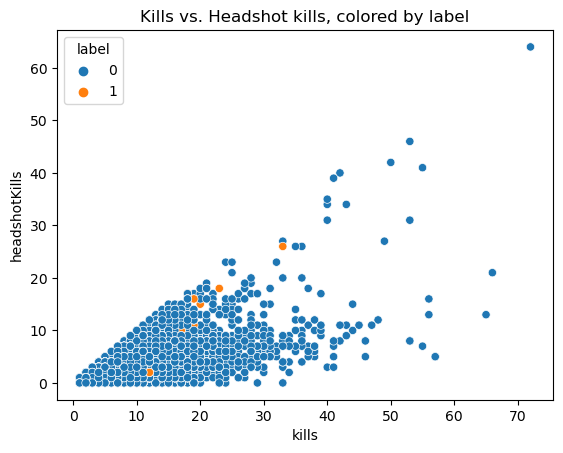

In [106]:
sns.scatterplot(x = 'kills', y = 'headshotKills', hue = 'label', data = Rule_Based_DF)
plt.title("Kills vs. Headshot kills, colored by label")

In [107]:
Percentile_Rules = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Cheaters Detected: {Rule_Based_Cheaters.shape}, Cheater Percentage: {Percentile_Rules}')

Cheaters Detected: (1039, 8), Cheater Percentage: 0.0005419237196726134


We've created a better way to determine the highest end player and at least annotate that they might be a hacker/cheater - but our percentage is still far lower than 1%. We'll have to continue manipulating some of the fields. 

Regardless of the influence on win place percentage - boosts are not likely to be a very good confirmation of a hacker (boosts are readily available to all players and there have no been hacks reported that allow people to spawn more boosts).

We will remove boosts in this iteration.

In [108]:
#Rule predictions with no boosts

def no_boost_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['winPlacePerc'] == 1.0 and row['kills'] > 5 and row['walkDistance'] > 3500 and row['longestKill'] > 200:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [109]:
Rule_Based_DF['label'] = no_boost_predict(Rule_Based_DF)

Rule_Based_Cheaters = Rule_Based_DF.loc[Rule_Based_DF['label'] == 1]

Rule_Based_Cheaters.sample(20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
1155996,12,2,8,207.3,4610.0,0.250000,1.0,1
824225,0,2,6,229.2,4327.0,0.333333,1.0,1
3418072,7,1,7,439.0,3899.0,0.142857,1.0,1
326238,1,0,6,329.2,3728.0,0.000000,1.0,1
2068755,2,3,6,346.4,5161.0,0.500000,1.0,1
3250706,6,2,7,225.5,3773.0,0.285714,1.0,1
762257,2,0,6,302.9,3953.0,0.000000,1.0,1
269759,8,0,7,393.6,4072.0,0.000000,1.0,1
2238176,1,6,10,831.7,3765.0,0.600000,1.0,1
2322730,7,9,12,324.7,3588.0,0.750000,1.0,1


Text(0.5, 1.0, 'Kills vs. Headshot kills, colored by label')

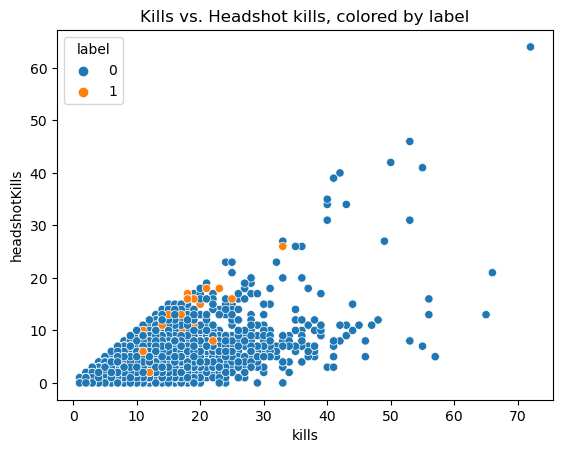

In [110]:
sns.scatterplot(x = 'kills', y = 'headshotKills', hue = 'label', data = Rule_Based_DF)
plt.title("Kills vs. Headshot kills, colored by label")

In [111]:
No_Boost_Rule = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Cheaters Detected: {Rule_Based_Cheaters.shape}, Cheater Percentage: {No_Boost_Rule}')

Cheaters Detected: (2455, 8), Cheater Percentage: 0.0012804838612091105


This iteration proved to be better in getting us closer to the 1% threshold. 

Next we'll take a look at some impossible events like high kills without large walk distances.

In [112]:
#High Kills/Low Walk Predict

def low_walk_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['winPlacePerc'] == 1.0 and row['kills'] > 5 and row['walkDistance'] < 1000 and row['longestKill'] > 200:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [113]:
Rule_Based_DF['label'] = low_walk_predict(Rule_Based_DF)

Rule_Based_Cheaters = Rule_Based_DF.loc[Rule_Based_DF['label'] == 1]

Rule_Based_Cheaters.sample(20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
4302242,0,4,17,286.3,403.20,0.235294,1.0,1
1928488,0,4,11,264.1,402.30,0.363636,1.0,1
877113,0,11,37,354.0,37.86,0.297297,1.0,1
2745718,0,2,11,211.6,324.40,0.181818,1.0,1
829086,1,10,36,200.9,64.94,0.277778,1.0,1
3049877,0,7,13,263.6,312.20,0.538462,1.0,1
1747819,0,19,28,234.8,38.96,0.678571,1.0,1
117124,0,2,6,223.0,191.90,0.333333,1.0,1
3342279,0,3,13,202.6,31.72,0.230769,1.0,1
2035747,0,18,37,253.7,52.47,0.486486,1.0,1


Text(0.5, 1.0, 'Kills vs. Headshot kills, colored by label')

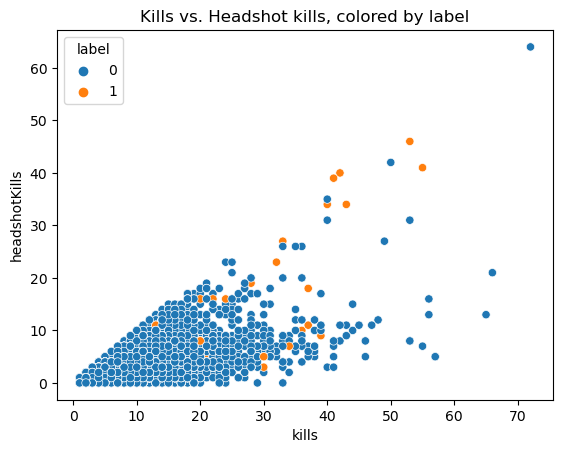

In [114]:
sns.scatterplot(x = 'kills', y = 'headshotKills', hue = 'label', data = Rule_Based_DF)
plt.title("Kills vs. Headshot kills, colored by label")

In [115]:
Low_Walk_Rule = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Cheaters Detected: {Rule_Based_Cheaters.shape}, Cheater Percentage: {Low_Walk_Rule}')

Cheaters Detected: (75, 8), Cheater Percentage: 3.911865156443311e-05


The low walk rule with high kills has probably isolated the most cheaters, but the percentage is far below 1%.


Let's combine some of the impossible events with the near impossible events for our last prediction

In [116]:
def combined_predict(df):
    
    predictions = []
    
    for index, row in df.iterrows():
        
        if row['winPlacePerc'] == 1.0 and row['kills'] > 5 and row['longestKill'] > 200:
            predictions.append(1)
        else:
            predictions.append(0)
        
    return predictions

In [117]:
#Have to do some slight changes because the function wouldn't let me do it properly

Rule_Based_DF_Final = Rule_Based_DF[(Rule_Based_DF["walkDistance"] < 1000) | (Rule_Based_DF["walkDistance"] >= 3000)]

In [118]:
Rule_Based_DF_Final['label'] = combined_predict(Rule_Based_DF_Final)

C:\Users\lmoor\AppData\Local\Temp\ipykernel_2108\3038355406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rule_Based_DF_Final['label'] = combined_predict(Rule_Based_DF_Final)


In [119]:
Rule_Based_Cheaters = Rule_Based_DF_Final.loc[Rule_Based_DF_Final['label'] == 1]
Rule_Based_Cheaters.sample(n=20)

,boosts,headshotKills,kills,longestKill,walkDistance,headshotPercentage,winPlacePerc,label
3663192,9,1,7,280.3,3241.0,0.142857,1.0,1
3237254,2,1,9,230.4,3265.0,0.111111,1.0,1
1200049,5,1,8,453.2,3427.0,0.125000,1.0,1
3519870,2,2,6,227.4,3455.0,0.333333,1.0,1
1642250,12,4,8,201.0,3289.0,0.500000,1.0,1
2173243,1,0,8,284.2,3107.0,0.000000,1.0,1
1499264,2,1,6,216.1,3192.0,0.166667,1.0,1
4198988,4,0,6,389.6,4709.0,0.000000,1.0,1
1274478,1,0,8,202.4,3699.0,0.000000,1.0,1
2610470,3,1,9,291.1,4663.0,0.111111,1.0,1


Text(0.5, 1.0, 'Kills vs. Headshot kills, colored by label')

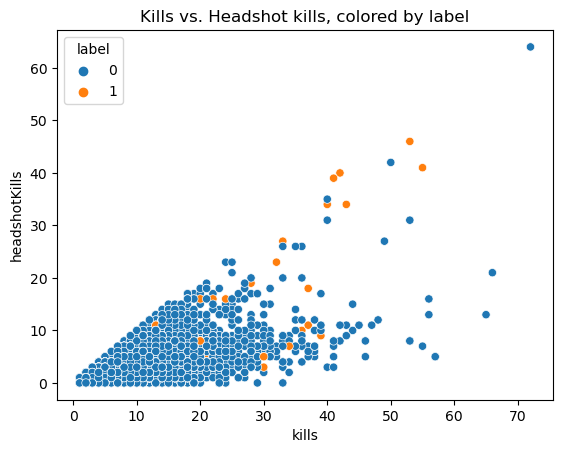

In [120]:
sns.scatterplot(x = 'kills', y = 'headshotKills', hue = 'label', data = Rule_Based_DF)
plt.title("Kills vs. Headshot kills, colored by label")

In [121]:
Combined_Rules = len(Rule_Based_Cheaters)/len(Rule_Based_DF)

print(f'Cheaters Detected: {Rule_Based_Cheaters.shape}, Cheater Percentage: {Combined_Rules}')

Cheaters Detected: (4360, 8), Cheater Percentage: 0.0022740976109457117


Our final prediction is showing a much bigger percentage of chearters with quite a few outliers being detected. It's not quite at our 1% threshold though. 

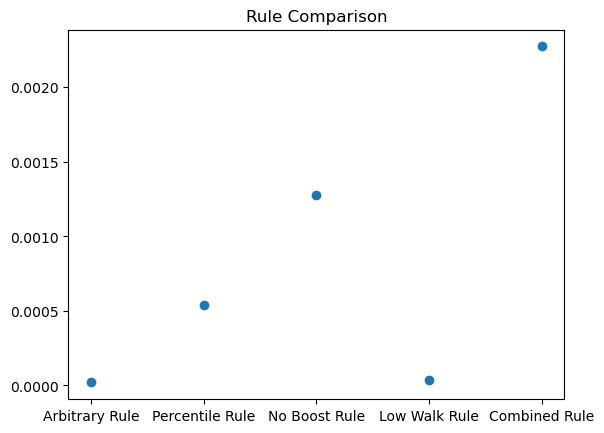

In [122]:
#Dictionary for the rule percentages

Rule_Dict = {"Arbitrary Rule": Arbitrary_Rules, "Percentile Rule": Percentile_Rules,"No Boost Rule": No_Boost_Rule, "Low Walk Rule": Low_Walk_Rule, "Combined Rule": Combined_Rules}
    
colors = list("rgbcmyk")

x = Rule_Dict.keys()

y = Rule_Dict.values()

plt.scatter(x,y)
plt.title("Rule Comparison")
plt.show()

By percentage of cheaters detected, the combined rule has the best accuracy. However, it is not able to reach our 1% threshold without further exploration. We will consider this to be too restrictive.

# Post Learning Analysis

Now that we've explored three types of potential labeling, there is a clear "winner" in meeting our requirements for cheating detection and the 1% threshold. 

The Local Outlier Factor performed the best, and we will use the data from that method to do some post analytics on the dataset and look for anything interesting we could use in the future to create a better cheat detection algorithm.

In [143]:
#Original Dataset

Post_DF = PUBG_Orig
Post_DF

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,label
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.000,0,0,244.80,1,1466,0.4444,NaN
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.040,0,0,1434.00,5,0,0.6400,NaN
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.000,0,0,161.80,2,0,0.7755,NaN
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.000,0,0,202.70,3,0,0.1667,NaN
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.000,0,0,49.75,2,0,0.1875,Normal Player
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786,NaN
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0.0000,0,0.000,0,0,81.70,6,0,0.2935,NaN
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0.0000,0,2.184,0,0,788.70,4,0,0.4815,NaN
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,0.0000,0,0.000,0,0,2748.00,8,0,0.8000,Normal Player


In [144]:
#Add Outlier_X labels to original dataset

Post_DF['label'] = Outlier_X['label']

In [145]:
#Engineer Features again

Post_DF['headshotPercentage'] = Post_DF['headshotKills'] / Post_DF['kills']

Post_DF['distanceTraveled'] = Post_DF['walkDistance'] + Post_DF['rideDistance'] + Post_DF['swimDistance']

Post_DF.loc[Post_DF['matchType'] == 'squad-fpp','matchType'] = "squad"
Post_DF.loc[Post_DF['matchType'] == 'duo-fpp','matchType'] = "duo"
Post_DF.loc[Post_DF['matchType'] == 'solo-fpp','matchType'] = "solo"
Post_DF.loc[Post_DF['matchType'] == 'normal-squad-fpp','matchType'] = "squad"
Post_DF.loc[Post_DF['matchType'] == 'crashfpp','matchType'] = "solo"
Post_DF.loc[Post_DF['matchType'] == 'normal-duo-fpp','matchType'] = "duo"
Post_DF.loc[Post_DF['matchType'] == 'normal-solo-fpp','matchType'] = "solo"
Post_DF.loc[Post_DF['matchType'] == 'flaretpp','matchType'] = "solo"
Post_DF.loc[Post_DF['matchType'] == 'flarefpp','matchType'] = "solo"
Post_DF.loc[Post_DF['matchType'] == 'crashtpp','matchType'] = "solo"
Post_DF.loc[Post_DF['matchType'] == 'normal-squad','matchType'] = "squad"
Post_DF.loc[Post_DF['matchType'] == 'normal-duo','matchType'] = "duo"
Post_DF.loc[Post_DF['matchType'] == 'normal-solo','matchType'] = "solo"

Post_DF.dropna(inplace = True)

In [146]:
PUBG_Post_DF.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
label              0
dtype: int64

In [147]:
Post_DF_Cheaters = Post_DF.loc[Post_DF['label'] == "Cheater"]

In [148]:
Post_DF_Cheaters.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,label,headshotPercentage,distanceTraveled
928,48fd7bfa52fa8b,da4028ea9e3608,b3eb9c2ff6e9ef,0,0,262.2,2,1,1,26,...,0.0,0,0,116.60,2,1514,0.1429,Cheater,0.500000,116.60
1156,de7f730eb91bc1,b531dacce13a6d,4c75c5df1a5b30,0,1,179.5,0,0,0,41,...,0.0,0,0,33.60,1,0,0.3163,Cheater,0.000000,33.60
1292,919f57a28a5e02,79a34f910375bc,b181e5bc4f0c1d,6,0,1750.0,0,6,2,7,...,0.0,0,0,1137.00,43,0,0.7143,Cheater,0.400000,2794.00
1351,32220283493bc2,a5984ead1bd844,bba3cad7be7edd,2,0,655.2,0,2,0,11,...,0.0,0,0,29.57,9,1500,0.4737,Cheater,0.333333,29.57
1469,406e454766c092,f7a0eed25a4647,3e66a2e4b379d8,0,6,200.0,0,0,1,16,...,0.0,0,0,968.20,8,0,0.8144,Cheater,0.000000,3061.20


Text(0.5, 1.0, 'Kills vs. Match Type')

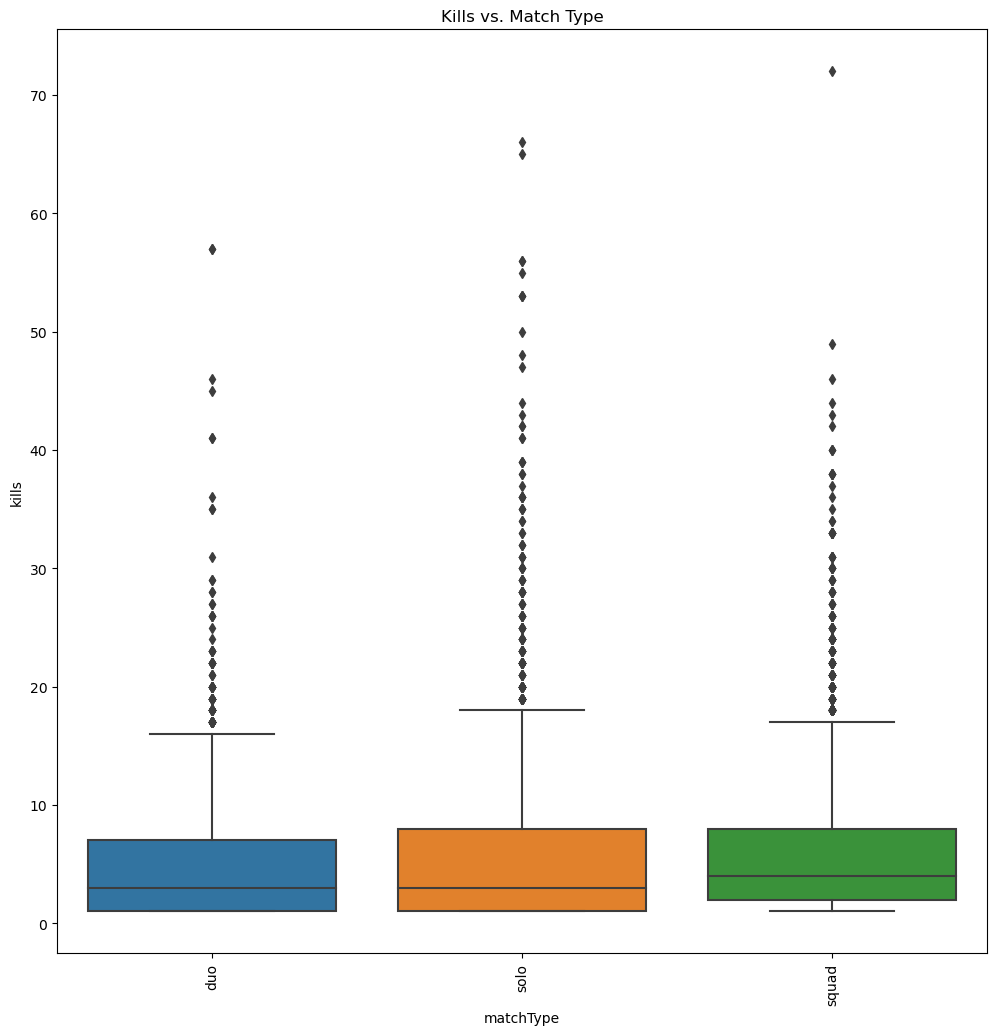

In [154]:
#Kills vs. Match Type

plt.figure(figsize=(12,12))
sns.boxplot(data = Post_DF_Cheaters, x = "matchType", y = "kills")
plt.xticks(rotation=90)
plt.title("Kills vs. Match Type")

<AxesSubplot:xlabel='walkDistance', ylabel='Count'>

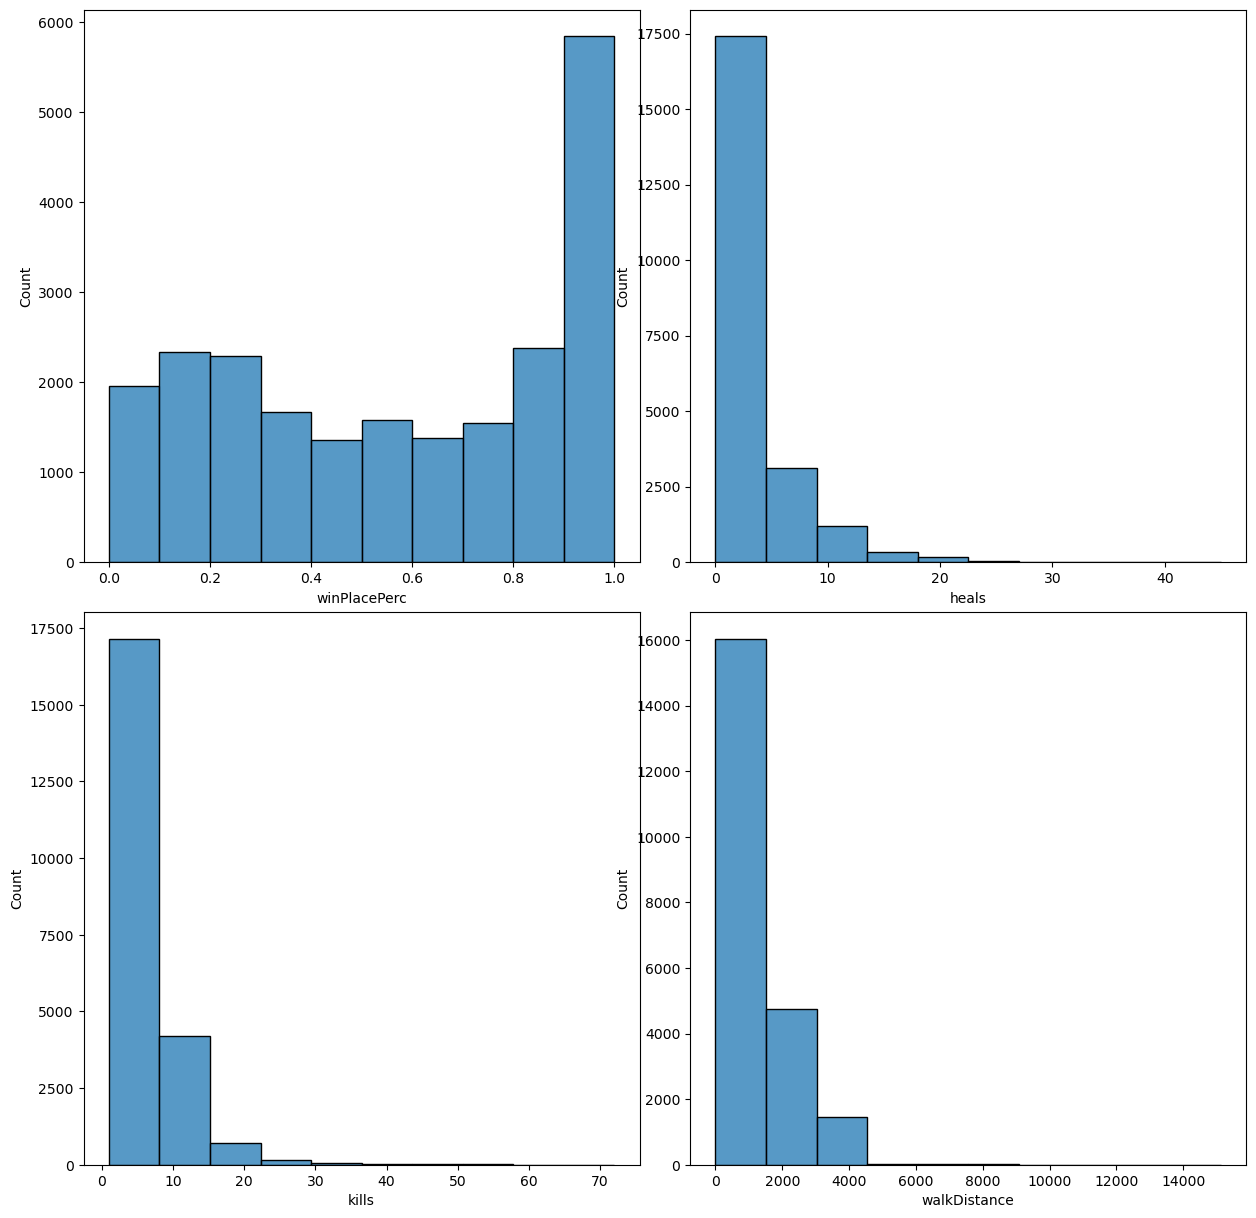

In [156]:
#Plot some high influential univariables for the cheating set

fig = plt.figure(figsize=(15, 15))

gridspec = fig.add_gridspec(4, 4)
ax0 = plt.subplot(gridspec[:2, :2])
ax1 = plt.subplot(gridspec[2:, :2])
ax2 = plt.subplot(gridspec[:2, 2:])
ax3 = plt.subplot(gridspec[2:, 2:])

sns.histplot(data = Post_DF_Cheaters, x = 'winPlacePerc', bins = 10, ax=ax0)
sns.histplot(data = Post_DF_Cheaters, x = 'kills', bins = 10, ax=ax1)
sns.histplot(data = Post_DF_Cheaters, x = 'heals', bins = 10, ax=ax2)
sns.histplot(data = Post_DF_Cheaters, x = 'walkDistance', bins = 10, ax=ax3)


<AxesSubplot:xlabel='distanceTraveled', ylabel='Count'>

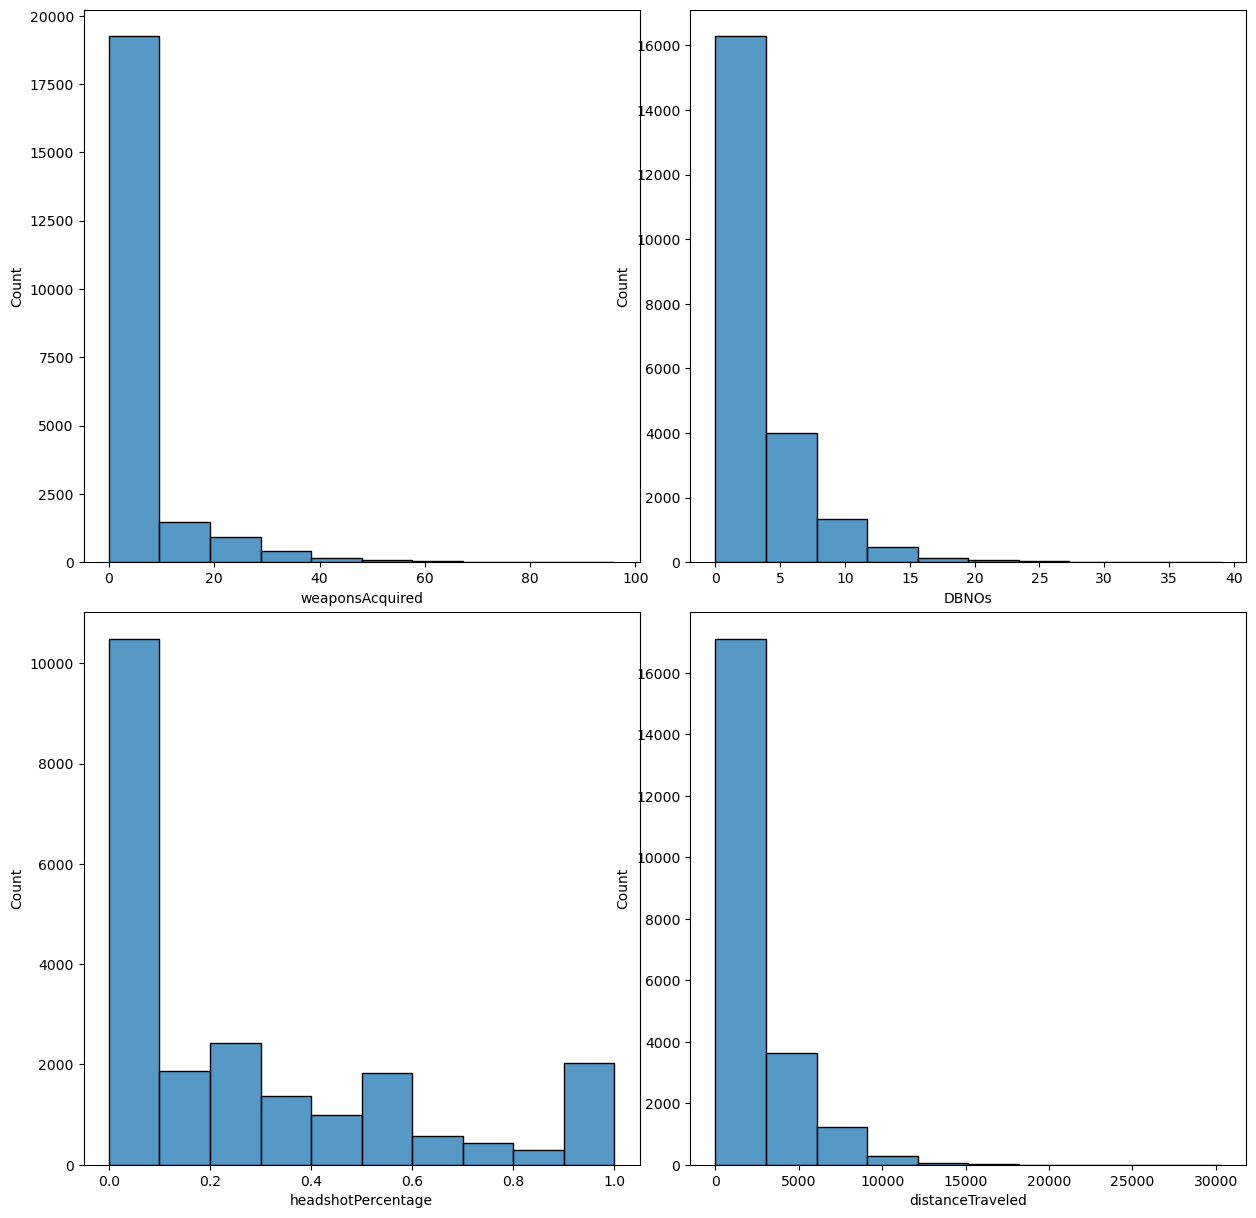

In [152]:
#Plot some less influential univariables for the cheating set

fig = plt.figure(figsize=(15, 15))

gridspec = fig.add_gridspec(4, 4)
ax0 = plt.subplot(gridspec[:2, :2])
ax1 = plt.subplot(gridspec[2:, :2])
ax2 = plt.subplot(gridspec[:2, 2:])
ax3 = plt.subplot(gridspec[2:, 2:])

sns.histplot(data = Post_DF_Cheaters, x = 'weaponsAcquired', bins = 10, ax=ax0)
sns.histplot(data = Post_DF_Cheaters, x = 'headshotPercentage', bins = 10, ax=ax1)
sns.histplot(data = Post_DF_Cheaters, x = 'DBNOs', bins = 10, ax=ax2)
sns.histplot(data = Post_DF_Cheaters, x = 'distanceTraveled', bins = 10, ax=ax3)


<AxesSubplot:xlabel='kills', ylabel='heals'>

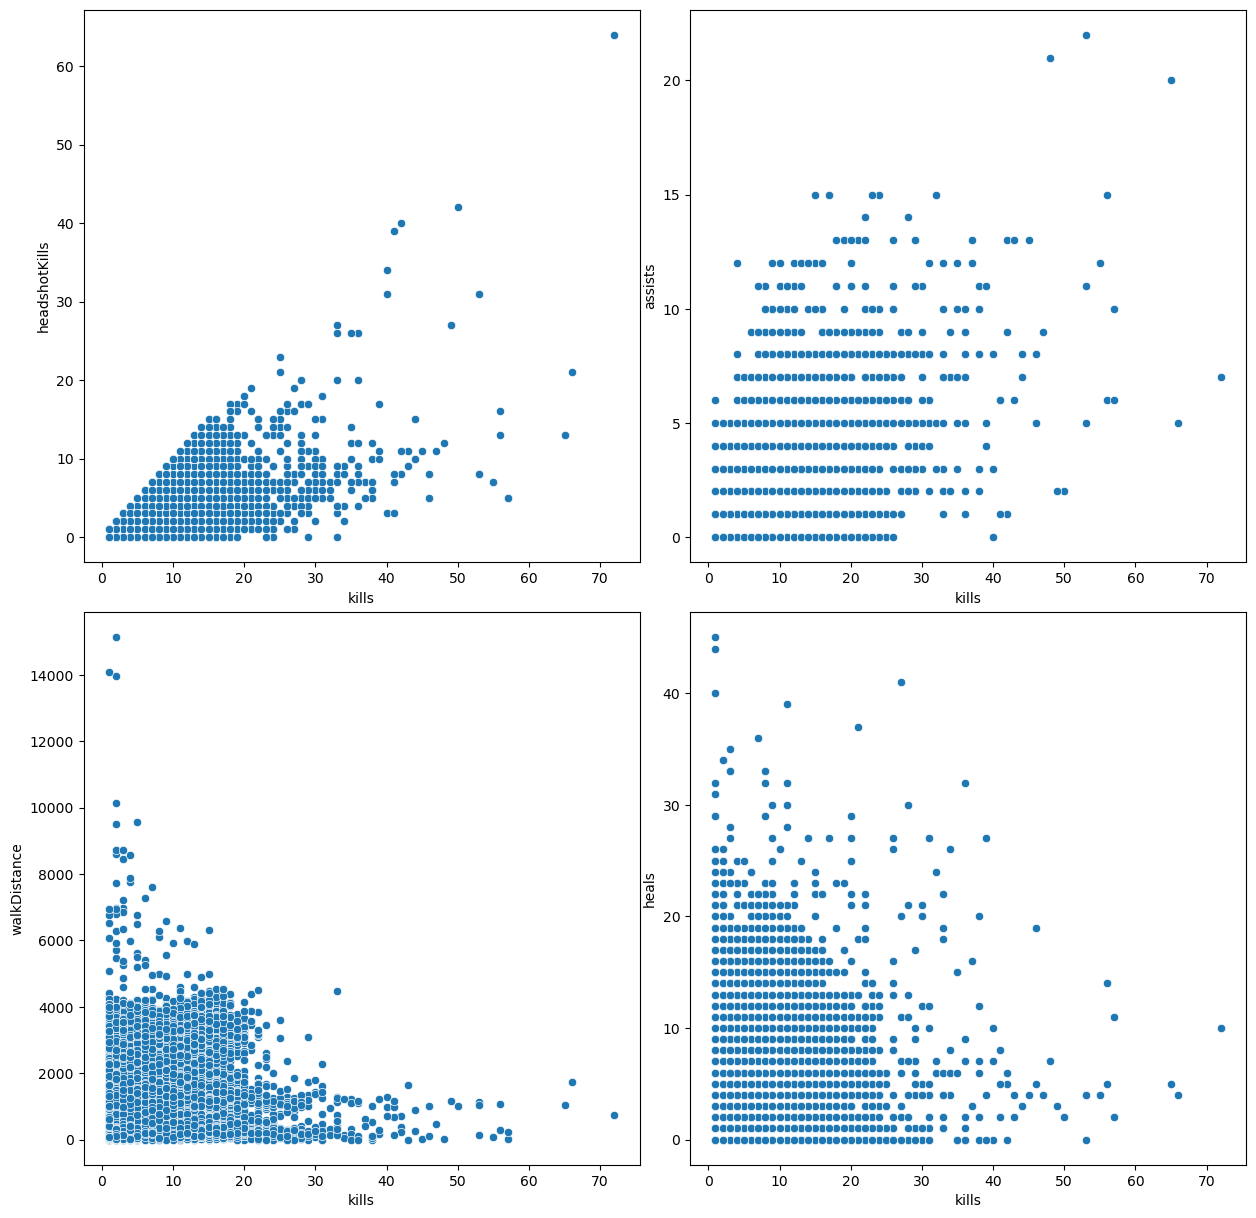

In [155]:
#Plot some kill relationships for the cheating set

fig = plt.figure(figsize=(15, 15))

gridspec = fig.add_gridspec(4, 4)
ax0 = plt.subplot(gridspec[:2, :2])
ax1 = plt.subplot(gridspec[2:, :2])
ax2 = plt.subplot(gridspec[:2, 2:])
ax3 = plt.subplot(gridspec[2:, 2:])

sns.scatterplot(data = Post_DF_Cheaters, x = "kills", y = "headshotKills", ax=ax0)
sns.scatterplot(data = Post_DF_Cheaters, x = "kills", y = "walkDistance", ax=ax1)
sns.scatterplot(data = Post_DF_Cheaters, x = "kills", y = "assists", ax=ax2)
sns.scatterplot(data = Post_DF_Cheaters, x = "kills", y = "heals", ax=ax3)

<AxesSubplot:xlabel='winPlacePerc', ylabel='heals'>

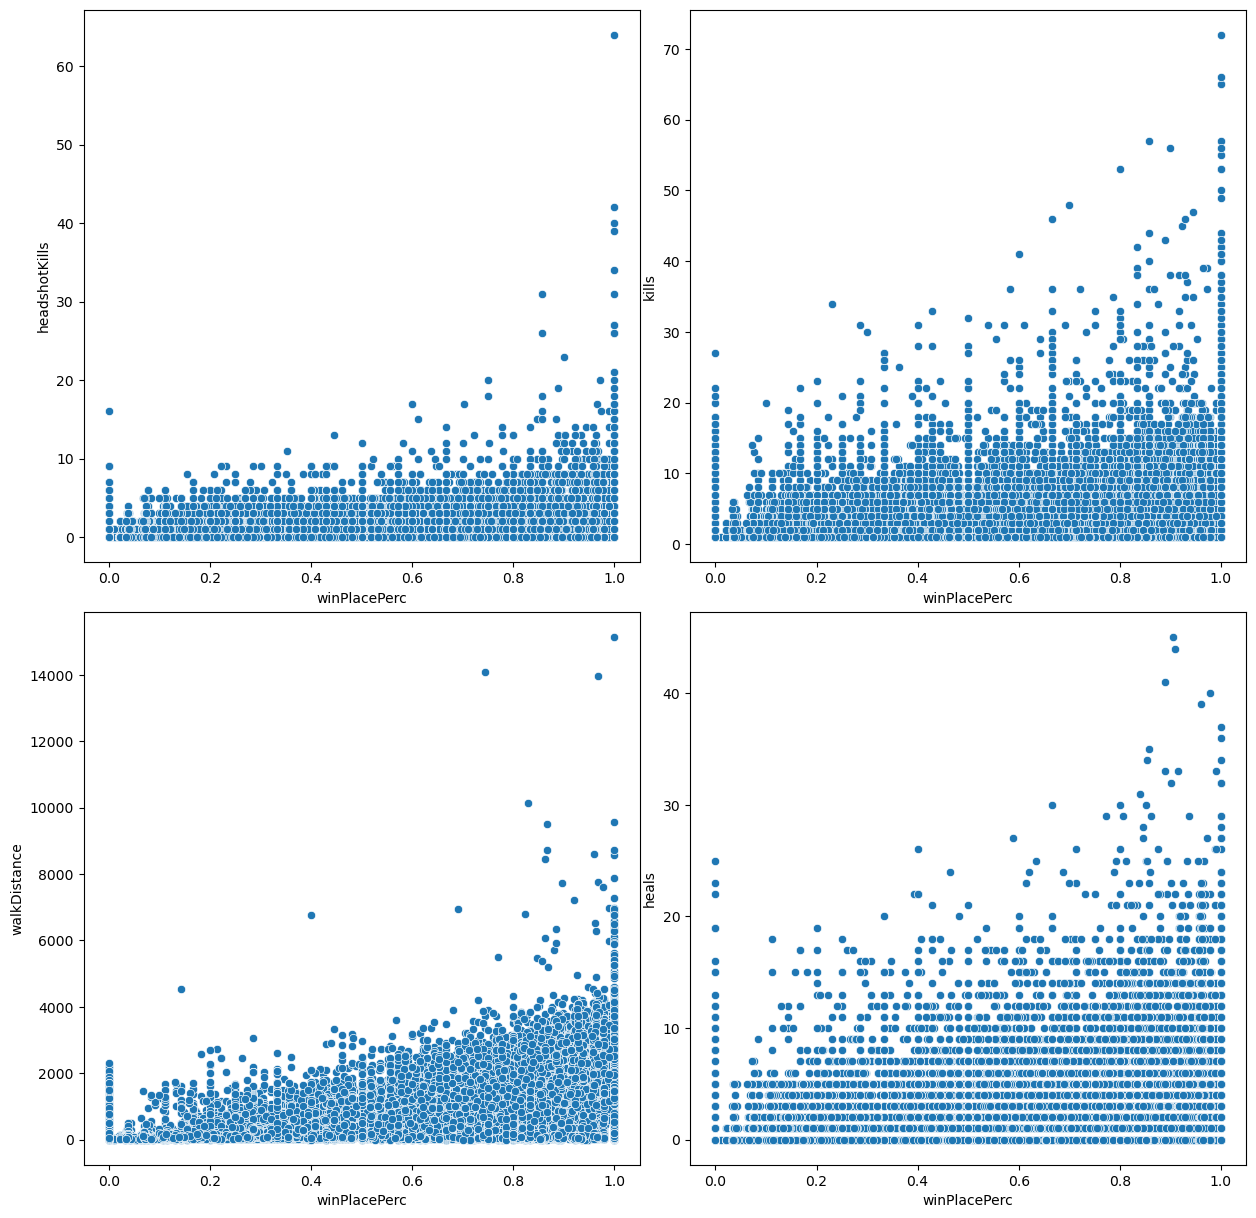

In [157]:
#Plot some winPlacePerc relationships for the cheating set

fig = plt.figure(figsize=(15, 15))

gridspec = fig.add_gridspec(4, 4)
ax0 = plt.subplot(gridspec[:2, :2])
ax1 = plt.subplot(gridspec[2:, :2])
ax2 = plt.subplot(gridspec[:2, 2:])
ax3 = plt.subplot(gridspec[2:, 2:])

sns.scatterplot(data = Post_DF_Cheaters, x = "winPlacePerc", y = "headshotKills", ax=ax0)
sns.scatterplot(data = Post_DF_Cheaters, x = "winPlacePerc", y = "walkDistance", ax=ax1)
sns.scatterplot(data = Post_DF_Cheaters, x = "winPlacePerc", y = "kills", ax=ax2)
sns.scatterplot(data = Post_DF_Cheaters, x = "winPlacePerc", y = "heals", ax=ax3)

Write some post analysis shit here after you do your paper.